#### <a id='toc1_1_1_1_'></a>[**Background**](#toc0_)


In the retail industry, it is essential to manage different store branches to effectively allocate resources and plan strategies ahead. In this work, I will work on Sales Prediction for 45 Walmart Stores. 

**Table of contents**<a id='toc0_'></a>    
    [**Step 1: Import Libraries and Data**](#toc1_1_1_2_)    
    [**Step 2: Data Preprocessing**](#toc1_1_1_3_)    
    [**Step 3: Data Exploration**](#toc1_1_1_4_)    
    [**Step 4: Feature Engineering**](#toc1_1_1_5_)    
    [**Step 5: Predictive Models**](#toc1_1_1_6_)    
        - [SARIMAX](#toc1_1_1_6_1_)    
        - [Random Forest Regressor](#toc1_1_1_6_3_)    
        - [Prophet](#toc1_1_1_6_4_)    
        - [XGBoost](#toc1_1_1_6_5_)    
        - [Prophet + XGBoost](#toc1_1_1_6_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

#### <a id='toc1_1_1_2_'></a>[**Step 1: Import Libraries and Data**](#toc0_)

In [98]:
## import libraries

# data manipulation
import numpy as np
import pandas as pd

# plot
import seaborn as sns
import matplotlib.pyplot as plt

# date-time
import math 
from datetime import datetime

# for models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import prophet

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [99]:
## import necessary datasets
df_store = pd.read_csv('stores.csv')
df_train = pd.read_csv('train.csv')
df_features = pd.read_csv('features.csv')

In [100]:
# dataset columns
df_store.columns = df_store.columns.str.lower()
df_train.columns = df_train.columns.str.lower()
df_features.columns = df_features.columns.str.lower()

# aggregate weekly sales data over department 
df_train = df_train.groupby(['store','date','isholiday'])['weekly_sales'].mean().reset_index()

In [101]:
# merge datasets
print(df_store.shape, df_train.shape, df_features.shape)

(45, 3) (6435, 4) (8190, 12)


In [102]:
# date columns to type datetime 
df_train['date'] = pd.to_datetime(df_train['date'])
df_features['date'] = pd.to_datetime(df_features['date'])

In [103]:
# merge dataset based on store_id & date
df = df_train.merge(df_store, on = 'store', how = 'left').merge(df_features,
         on = ['store', 'date'], how = 'left')
df = df.copy()
df.drop(columns = 'isholiday_y', inplace = True)
df.rename(columns = {'isholiday_x': 'isholiday'}, inplace = True)

#### <a id='toc1_1_1_3_'></a>[**Step 2: Data Preprocessing**](#toc0_)

In [104]:
# descriptive stats
df.describe()

store                 date  weekly_sales           size  \
count  6435.000000                 6435   6435.000000    6435.000000   
mean     23.000000  2011-06-17 00:00:00  15438.235889  130287.600000   
min       1.000000  2010-02-05 00:00:00   4072.448594   34875.000000   
25%      12.000000  2010-10-08 00:00:00   9437.672870   70713.000000   
50%      23.000000  2011-06-17 00:00:00  13981.704667  126512.000000   
75%      34.000000  2012-02-24 00:00:00  20073.017942  202307.000000   
max      45.000000  2012-10-26 00:00:00  54552.663571  219622.000000   
std      12.988182                  NaN   7293.360012   63117.022465   

       temperature   fuel_price     markdown1      markdown2      markdown3  \
count  6435.000000  6435.000000   2280.000000    1637.000000    2046.000000   
mean     60.663782     3.358607   6855.587430    3218.965504    1349.853021   
min      -2.060000     2.472000      0.270000    -265.760000     -29.100000   
25%      47.460000     2.933000   1679.190000      37.200000       4.700000   
50%      62.670000     3.445000   4972.590000     187.040000      22.700000   
75%      74.940000     3.735000   8873.582500    1785.290000      99.987500   
max     100.140000     4.468000  88646.760000  104519.540000  141630.610000   
std      18.444933     0.459020   8183.310015    9268.082387    9287.242800   

          markdown4      markdown5          cpi  unemployment  
count   1965.000000    2295.000000  6435.000000   6435.000000  
mean    3303.858142    4435.262240   171.578394      7.999151  
min        0.220000     135.160000   126.064000      3.879000  
25%      483.270000    1702.565000   131.735000      6.891000  
50%     1419.420000    3186.520000   182.616521      7.874000  
75%     3496.080000    5422.080000   212.743293      8.622000  
max    67474.850000  108519.280000   227.232807     14.313000  
std     6211.203947    5868.933325    39.356712      1.875885

In [105]:
# count null values in dataset 
df.isna().mean()

store           0.000000
date            0.000000
isholiday       0.000000
weekly_sales    0.000000
type            0.000000
size            0.000000
temperature     0.000000
fuel_price      0.000000
markdown1       0.645688
markdown2       0.745610
markdown3       0.682051
markdown4       0.694639
markdown5       0.643357
cpi             0.000000
unemployment    0.000000
dtype: float64

In [106]:
# exclude weekly_sales < 0 
df = df[df['weekly_sales']>0]

In [107]:
# change markdown columns na to 0
df.fillna(0, inplace = True)

In [108]:
# change data type for datetime column & create month and year columns
df['month'] = pd.to_datetime(df['date']).dt.month
df['year'] = pd.to_datetime(df['date']).dt.year
df['week'] = pd.to_datetime(df['date']).dt.isocalendar().week

In [109]:
# construct bool columns for each holiday type
## superbowl
df.loc[(df['date'] == '2010-02-12')|(df['date'] == '2011-02-11')|(df['date'] == '2012-02-10'),'super_bowl'] = True
df.loc[(df['date'] != '2010-02-12')&(df['date'] != '2011-02-11')&(df['date'] != '2012-02-10'),'super_bowl'] = False

## labor_day
df.loc[(df['date'] == '2010-09-10')|(df['date'] == '2011-09-09')|(df['date'] == '2012-09-07'),'labor_day'] = True
df.loc[(df['date'] != '2010-09-10')&(df['date'] != '2011-09-09')&(df['date'] != '2012-09-07'),'labor_day'] = False

## thanksgiving 
df.loc[(df['date'] == '2010-11-26')|(df['date'] == '2011-11-25'),'thanksgiving'] = True
df.loc[(df['date'] != '2010-11-26')&(df['date'] != '2011-11-25'),'thanksgiving'] = False

## christmas 
df.loc[(df['date'] == '2010-12-31')|(df['date'] == '2011-12-30'),'christmas'] = True
df.loc[(df['date'] != '2010-12-31')&(df['date'] != '2011-12-30'),'christmas'] = False


In [110]:
df.describe()

store                 date  weekly_sales           size  \
count  6435.000000                 6435   6435.000000    6435.000000   
mean     23.000000  2011-06-17 00:00:00  15438.235889  130287.600000   
min       1.000000  2010-02-05 00:00:00   4072.448594   34875.000000   
25%      12.000000  2010-10-08 00:00:00   9437.672870   70713.000000   
50%      23.000000  2011-06-17 00:00:00  13981.704667  126512.000000   
75%      34.000000  2012-02-24 00:00:00  20073.017942  202307.000000   
max      45.000000  2012-10-26 00:00:00  54552.663571  219622.000000   
std      12.988182                  NaN   7293.360012   63117.022465   

       temperature   fuel_price     markdown1      markdown2      markdown3  \
count  6435.000000  6435.000000   6435.000000    6435.000000    6435.000000   
mean     60.663782     3.358607   2429.019322     818.872810     429.184037   
min      -2.060000     2.472000      0.000000    -265.760000     -29.100000   
25%      47.460000     2.933000      0.000000       0.000000       0.000000   
50%      62.670000     3.445000      0.000000       0.000000       0.000000   
75%      74.940000     3.735000   2302.300000       0.090000       3.705000   
max     100.140000     4.468000  88646.760000  104519.540000  141630.610000   
std      18.444933     0.459020   5871.477726    4879.257489    5273.523172   

          markdown4      markdown5          cpi  unemployment        month  \
count   6435.000000    6435.000000  6435.000000   6435.000000  6435.000000   
mean    1008.870435    1581.806813   171.578394      7.999151     6.447552   
min        0.000000       0.000000   126.064000      3.879000     1.000000   
25%        0.000000       0.000000   131.735000      6.891000     4.000000   
50%        0.000000       0.000000   182.616521      7.874000     6.000000   
75%      314.320000    1983.265000   212.743293      8.622000     9.000000   
max    67474.850000  108519.280000   227.232807     14.313000    12.000000   
std     3753.943314    4098.198540    39.356712      1.875885     3.238308   

              year       week  
count  6435.000000     6435.0  
mean   2010.965035  25.818182  
min    2010.000000        1.0  
25%    2010.000000       14.0  
50%    2011.000000       26.0  
75%    2012.000000       38.0  
max    2012.000000       52.0  
std       0.797019  14.129201

#### <a id='toc1_1_1_4_'></a>[**Step 3: Data Exploration**](#toc0_)

In [111]:
# data viz in Tableau
df.to_csv('clean_data.csv', index = False)

<Axes: xlabel='date', ylabel='temperature'>

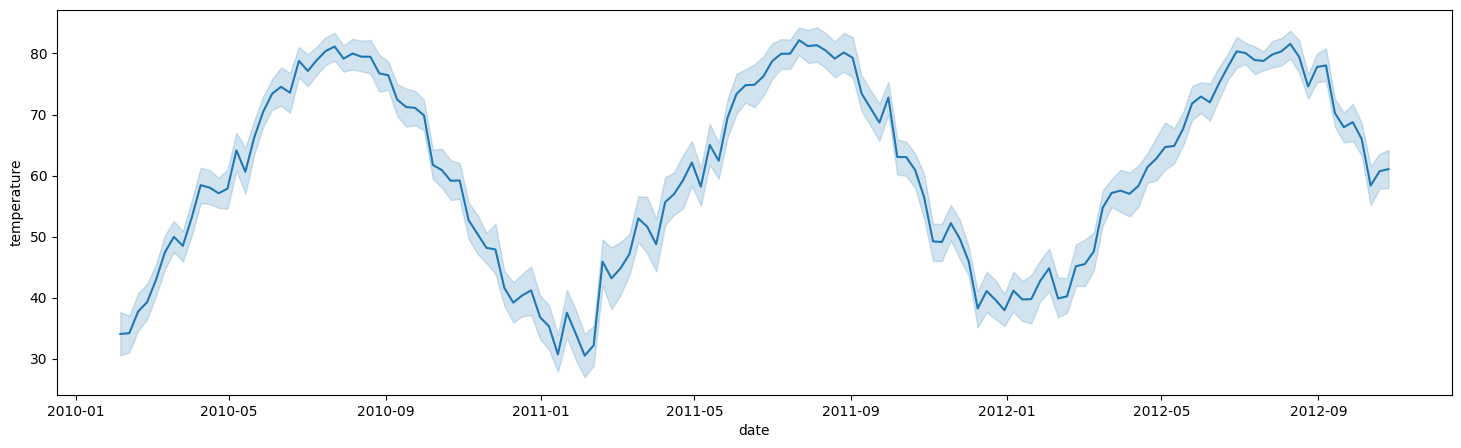

In [112]:
# temperature over time 
plt.figure(figsize=(18, 5))
sns.lineplot(x = 'date', y = 'temperature', data = df)

In [113]:
# temperature fluctuation differ by store
df.groupby('store')['temperature'].agg(['max', 'min','mean'])

max    min       mean
store                          
1       91.65  35.40  68.306783
2       93.34  33.02  68.216364
3       89.12  43.57  71.434196
4       86.09  28.84  62.253357
5       91.07  37.74  69.410140
6       91.46  38.37  69.700000
7       68.84  -2.06  39.720280
8       87.26  24.48  62.513986
9       91.63  31.82  67.775175
10      95.36  42.58  72.241189
11      91.44  44.61  72.480769
12      99.22  37.64  70.262797
13      83.68  16.94  53.697133
14      82.99  24.05  57.790979
15      79.97  19.53  51.833846
16      77.31  12.39  45.030070
17      74.20   6.23  46.387203
18      79.75  14.84  53.371259
19      79.37  20.66  52.295035
20      79.20  20.39  55.451399
21      94.22  34.14  68.847622
22      79.22  20.61  54.897133
23      77.16  10.91  48.805105
24      79.29  17.91  54.030000
25      78.10  18.30  52.138392
26      71.08   5.54  43.658252
27      82.69  23.64  57.311119
28      99.22  37.64  70.262797
29      79.22  20.61  54.897133
30      94.22  34.14  68.847622
31      94.22  34.14  68.847622
32      81.95  15.47  52.747552
33     100.14  46.25  76.728182
34      81.96  23.82  58.495874
35      82.69  23.64  57.311119
36      87.64  41.16  71.160350
37      87.64  41.16  71.160350
38      99.22  37.64  70.262797
39      88.65  40.34  70.597343
40      76.67   9.51  47.674545
41      76.54  14.56  48.410350
42      95.36  42.58  72.241189
43      91.36  33.21  68.877692
44      83.68  16.94  53.697133
45      82.99  24.05  57.790979

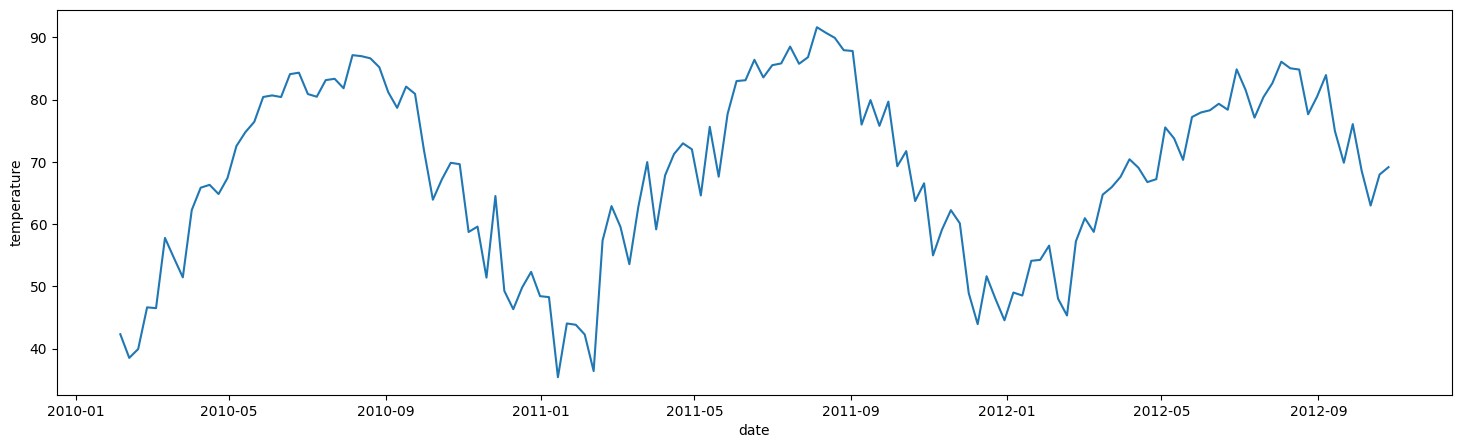

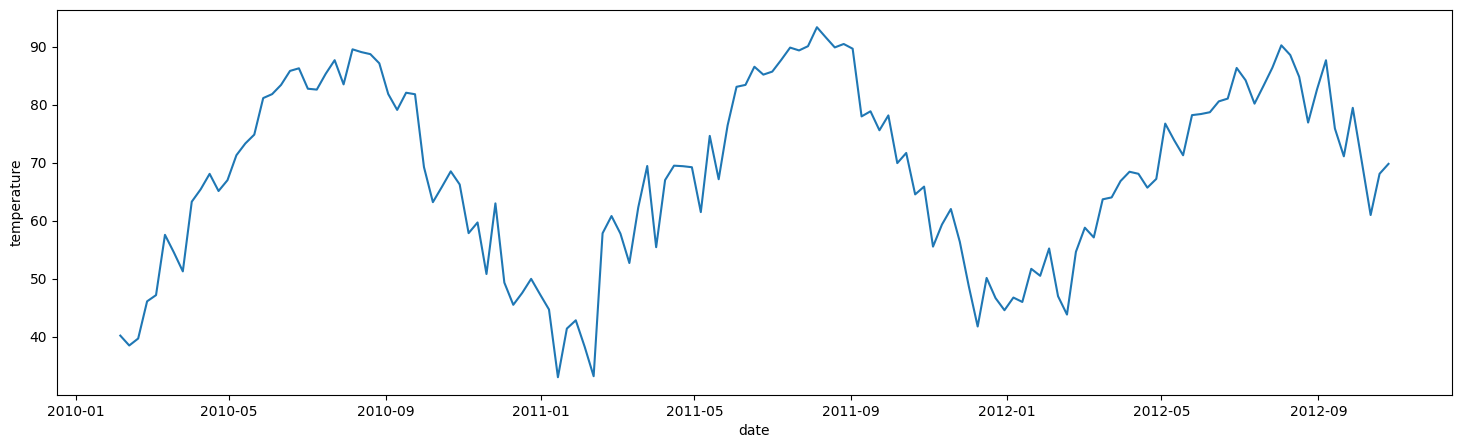

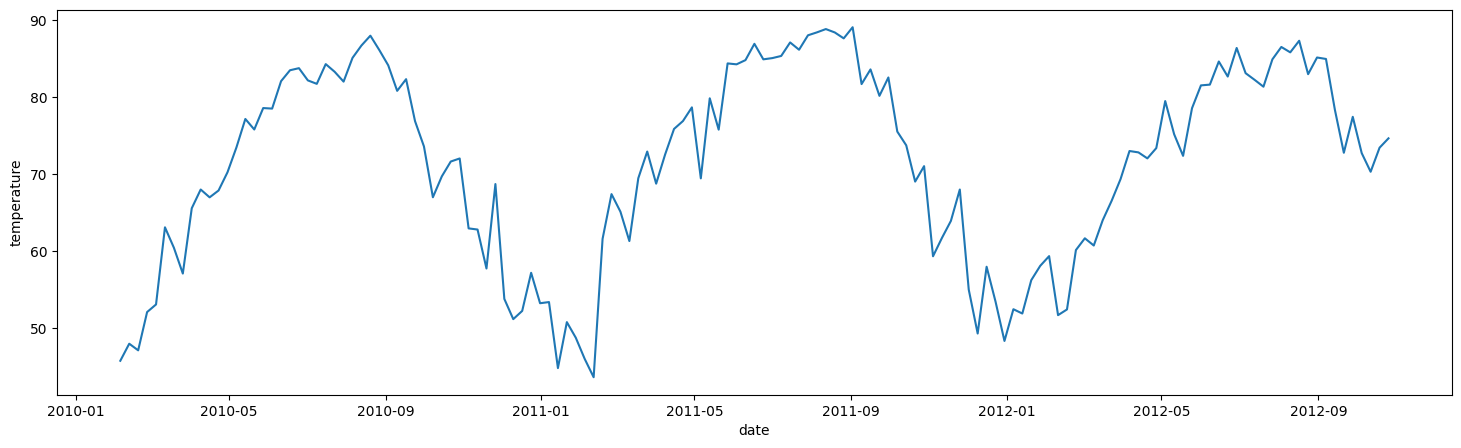

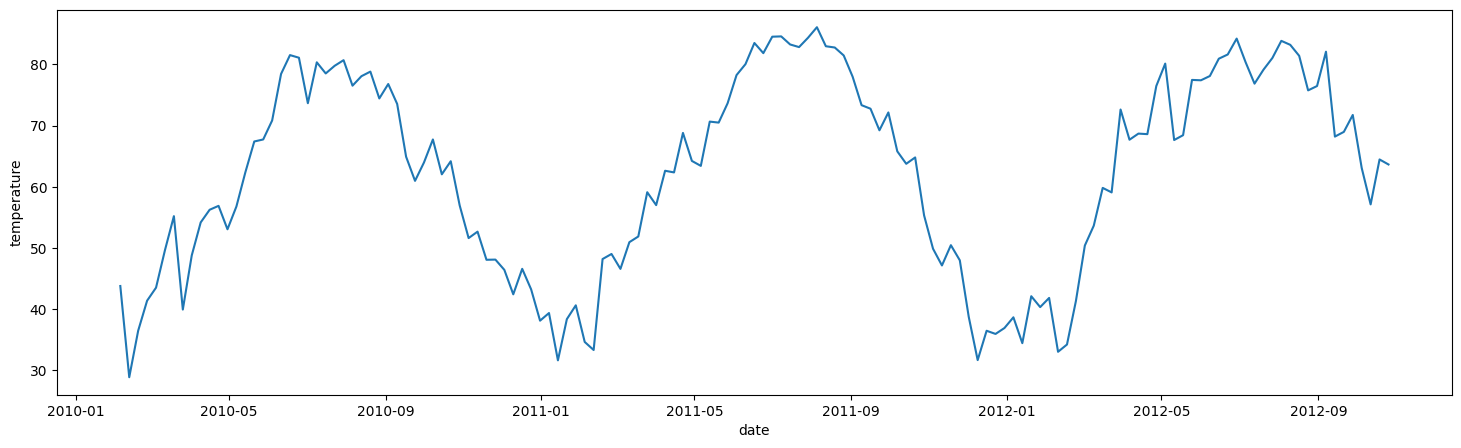

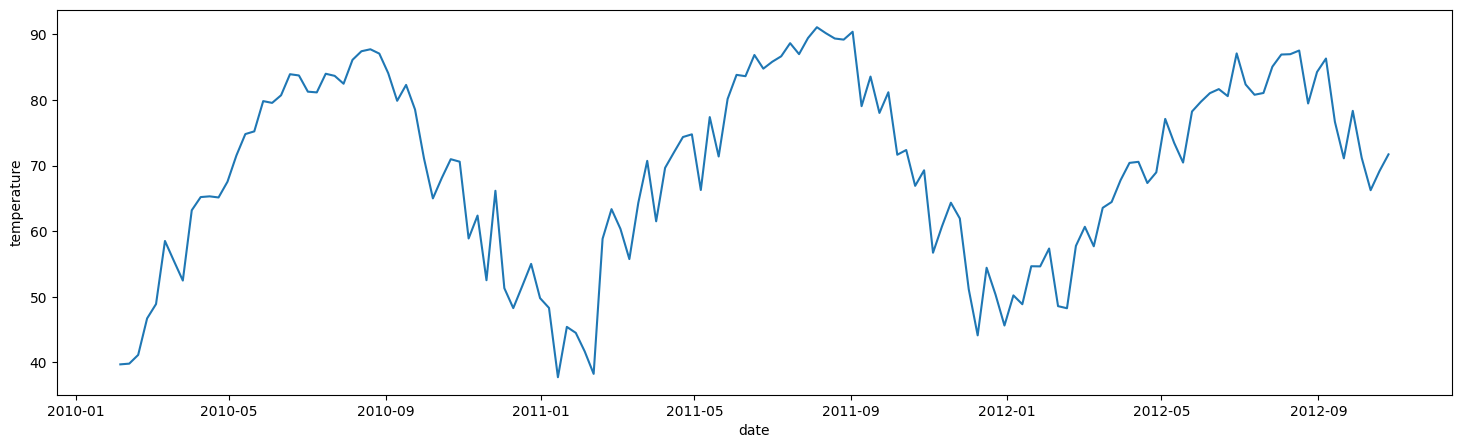

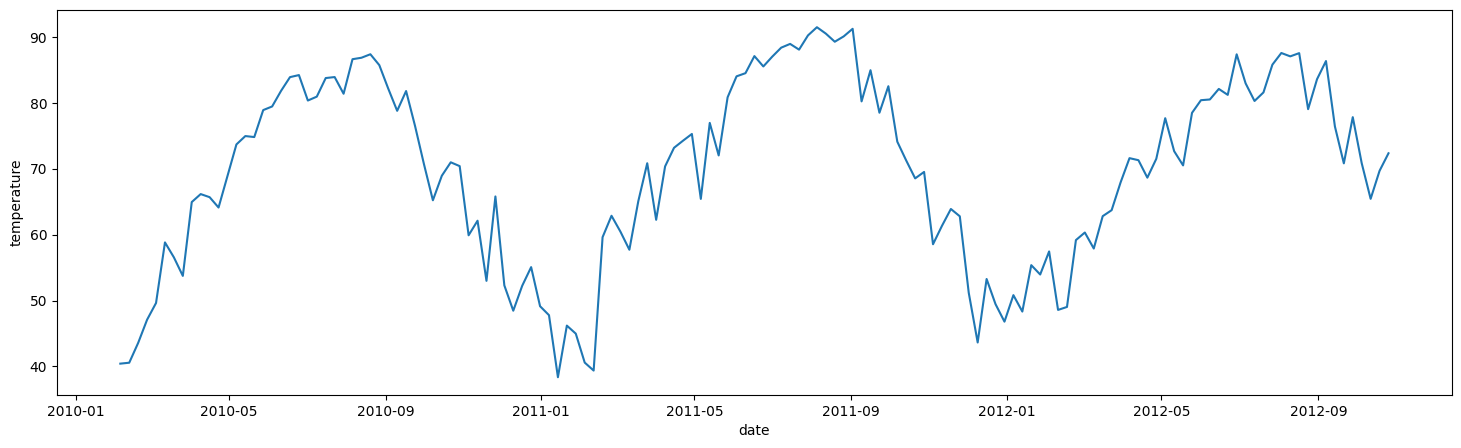

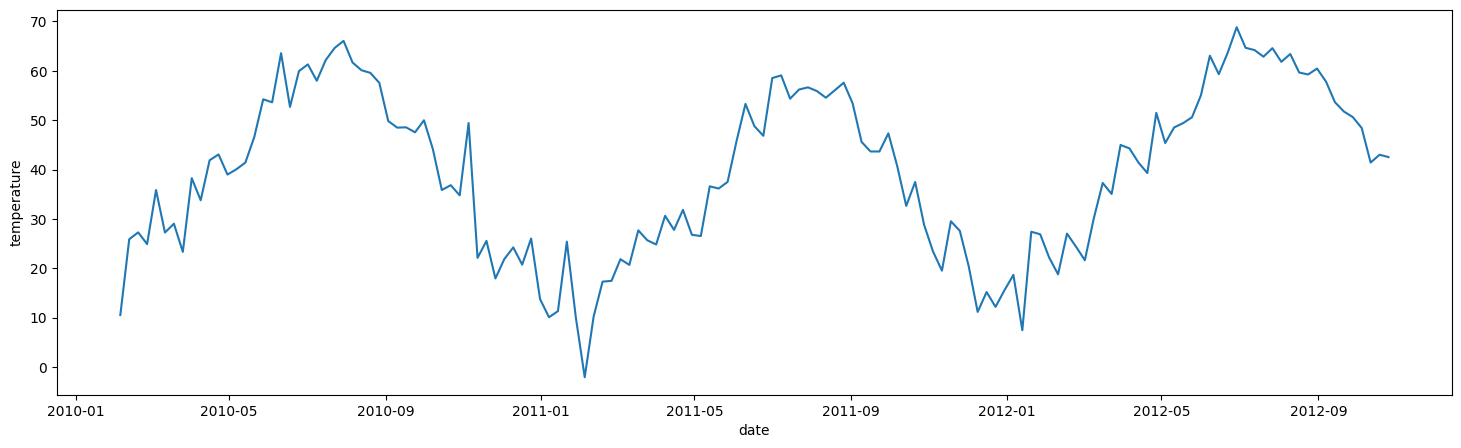

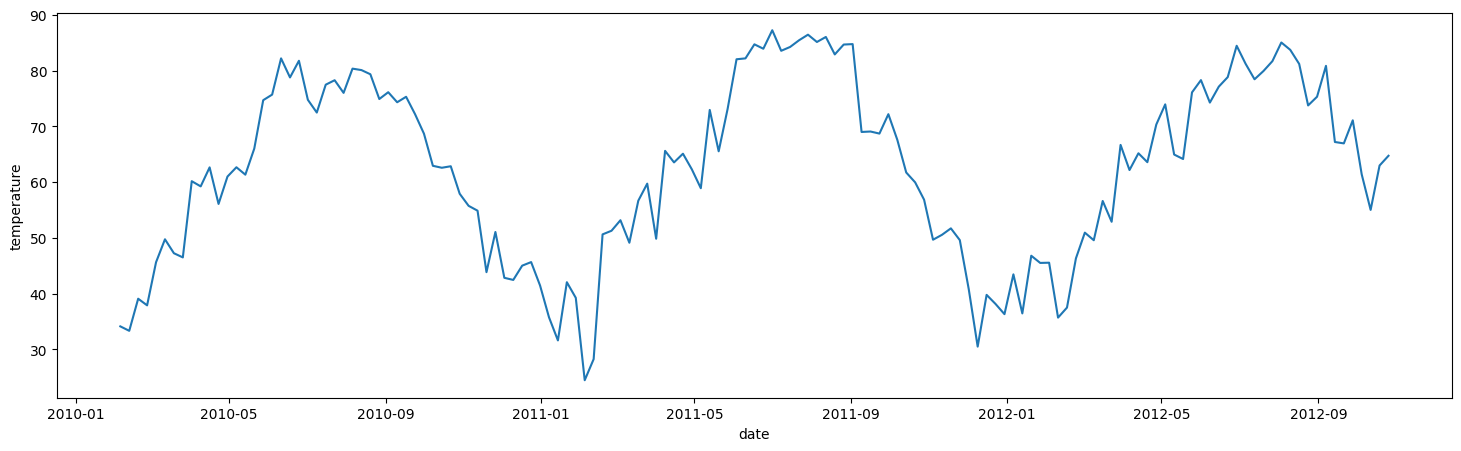

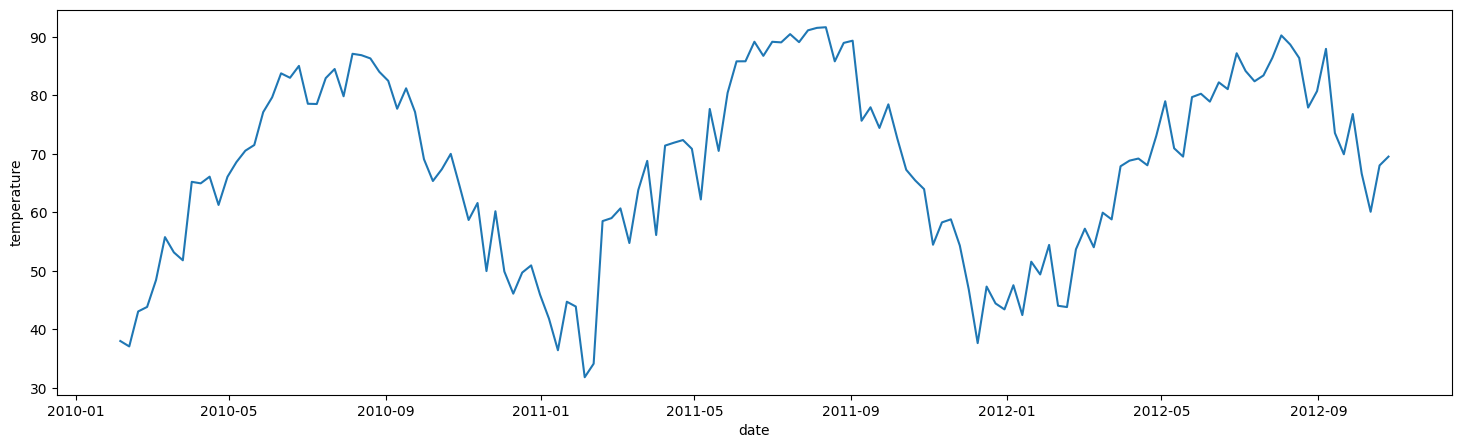

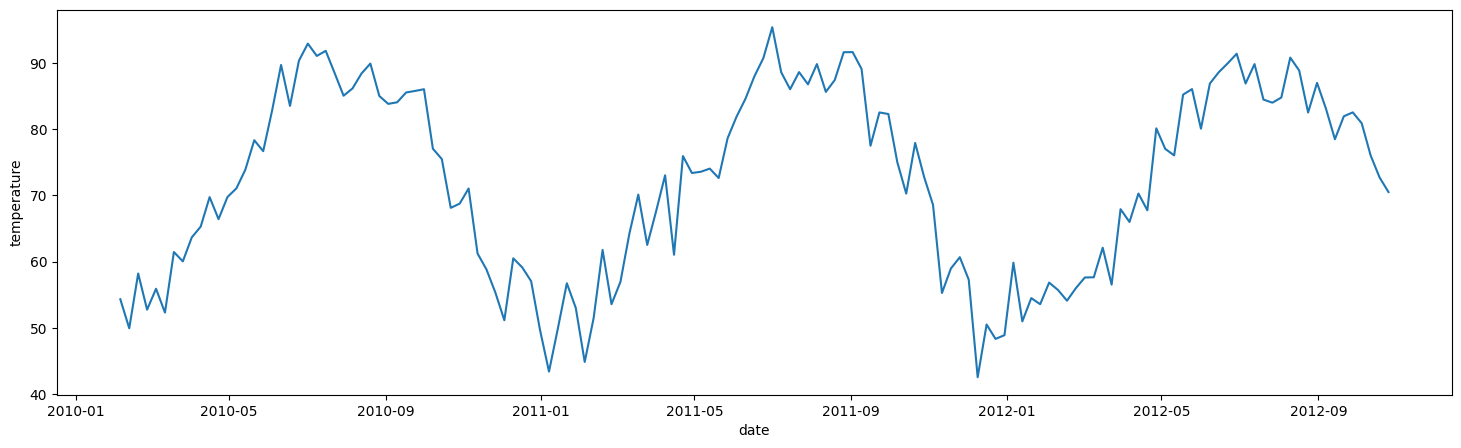

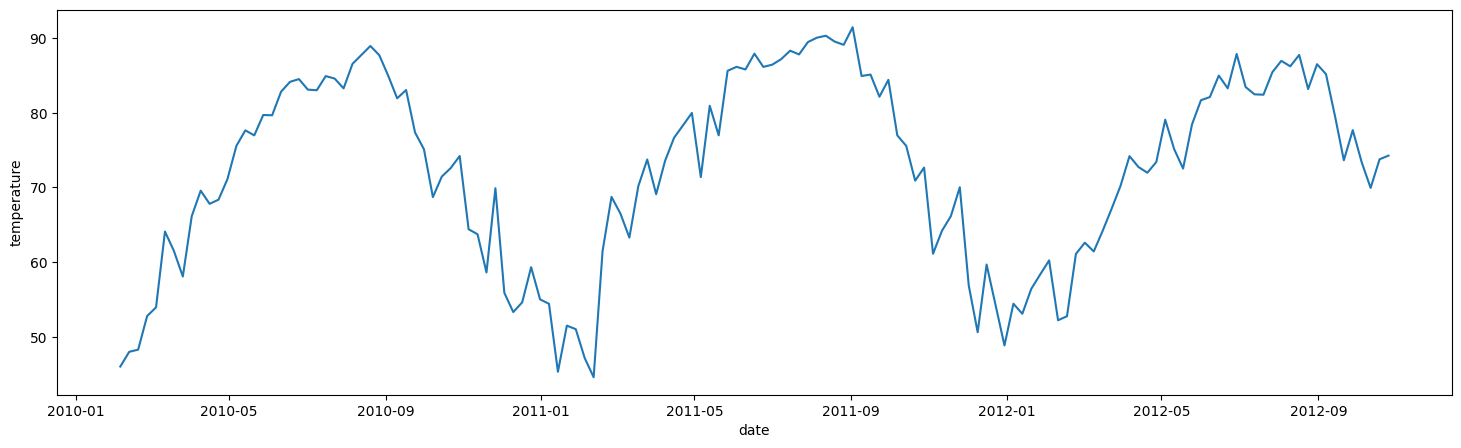

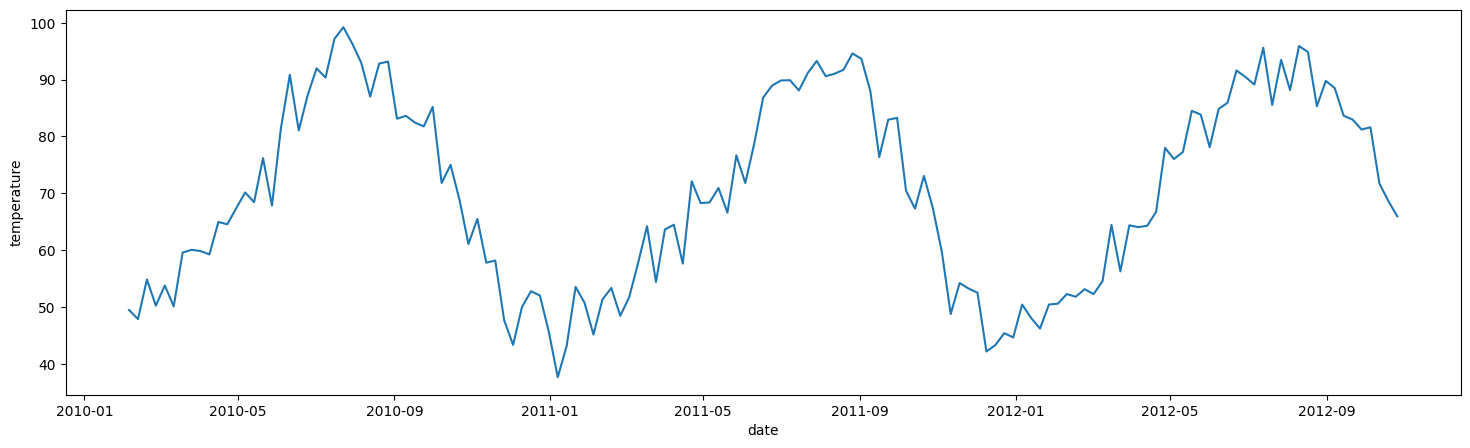

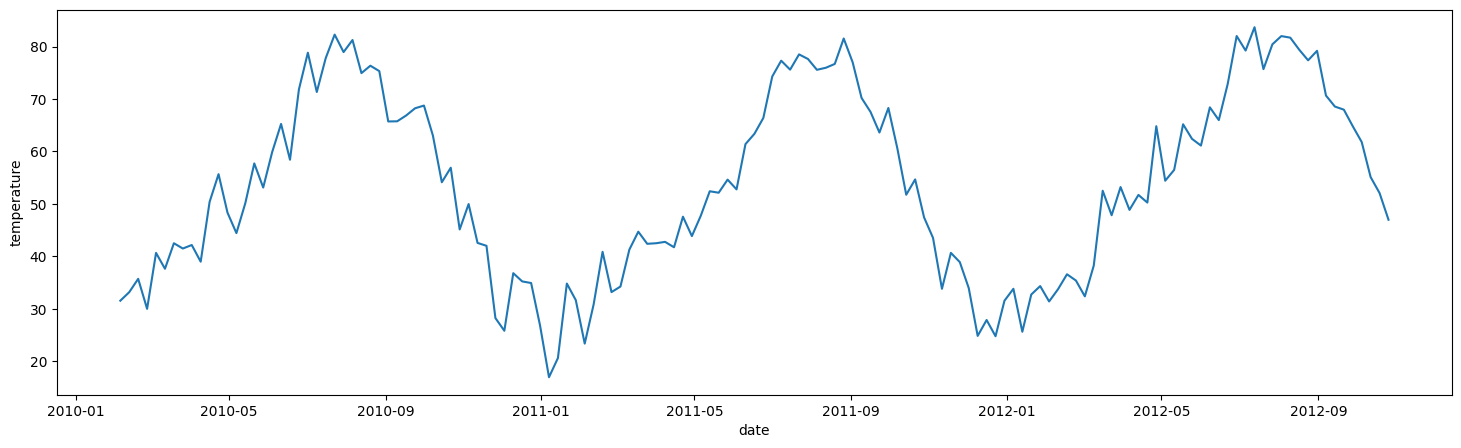

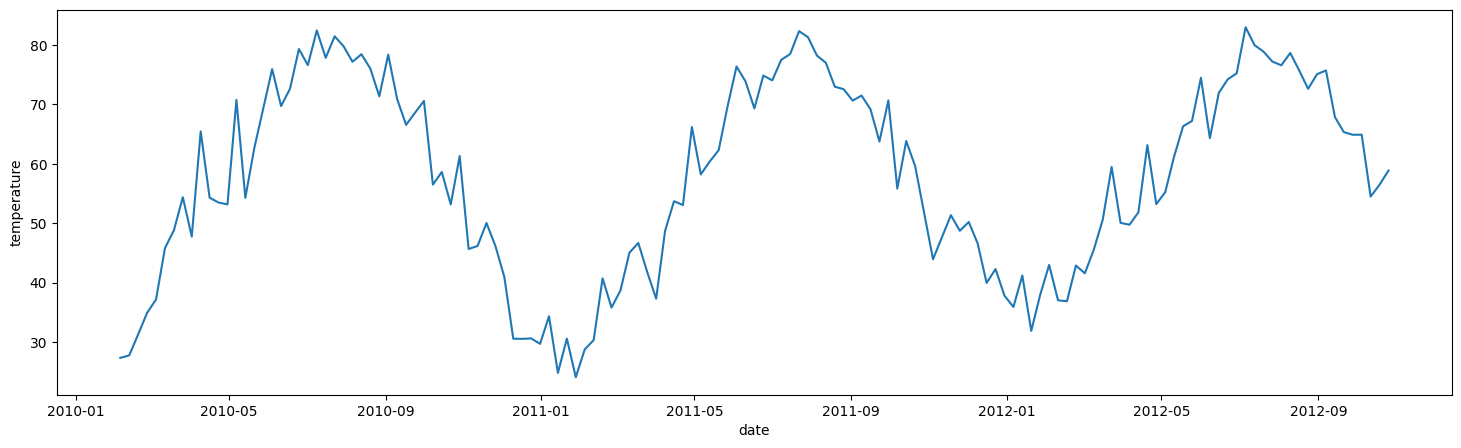

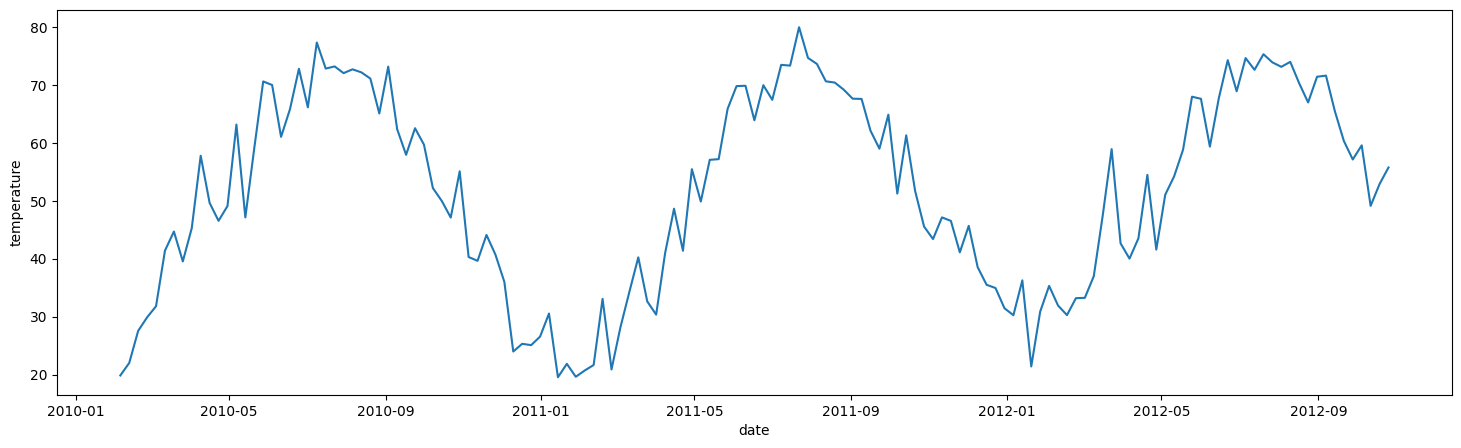

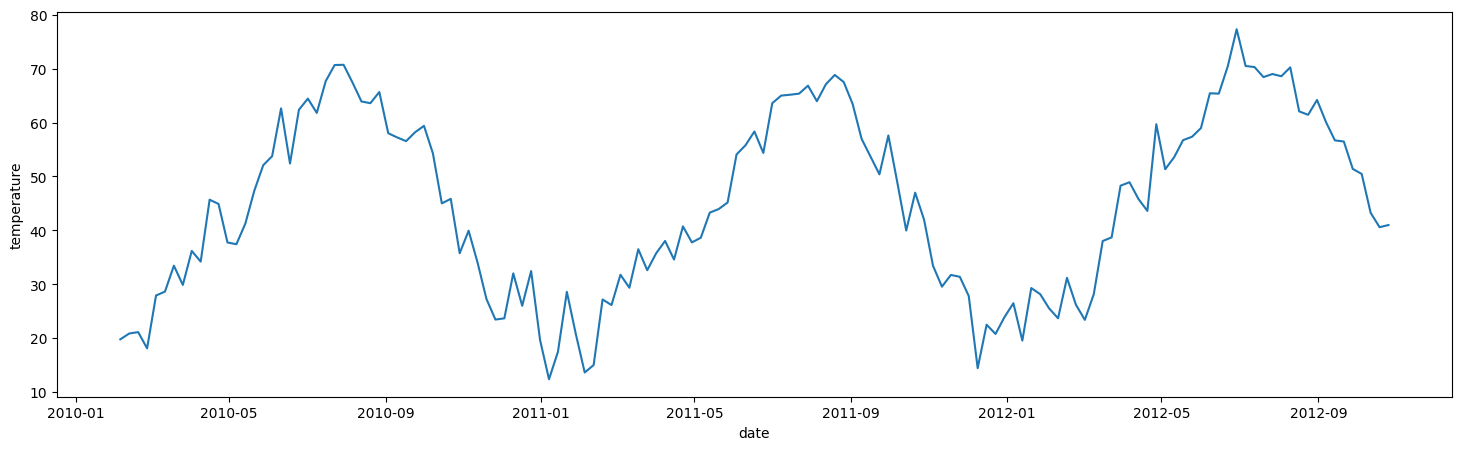

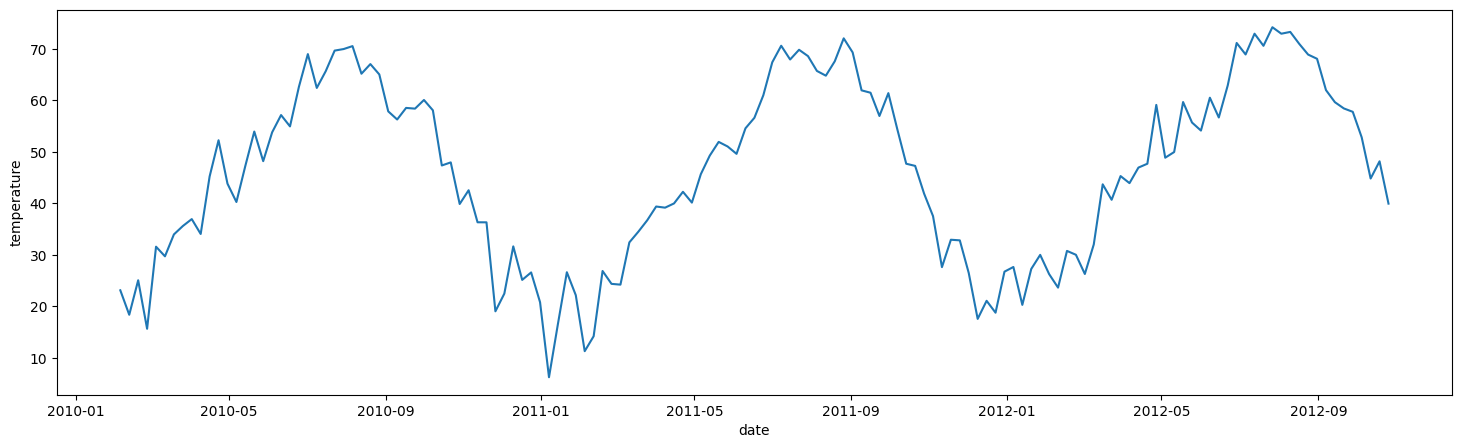

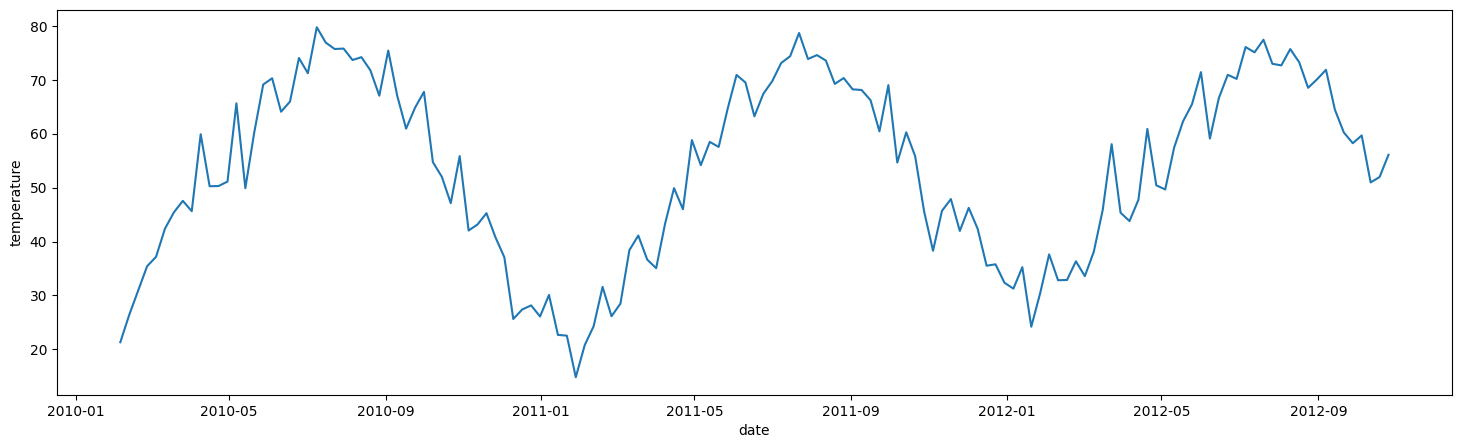

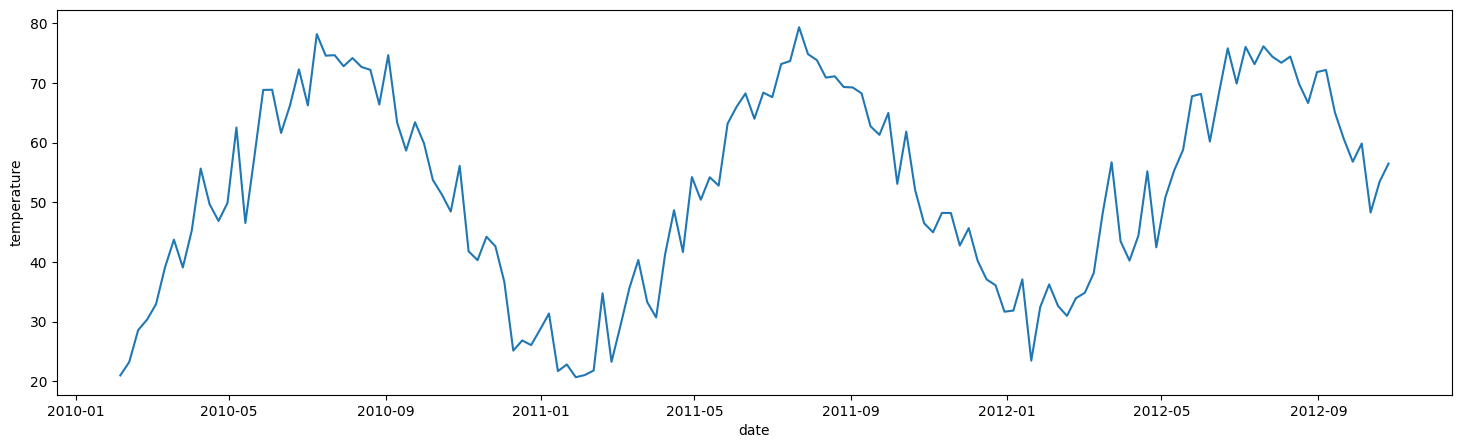

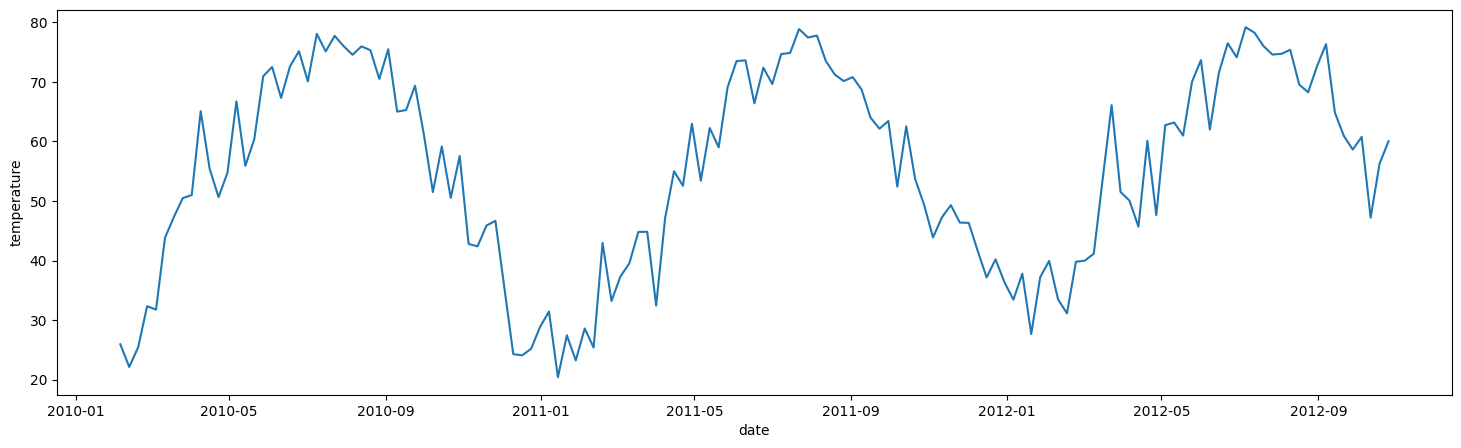

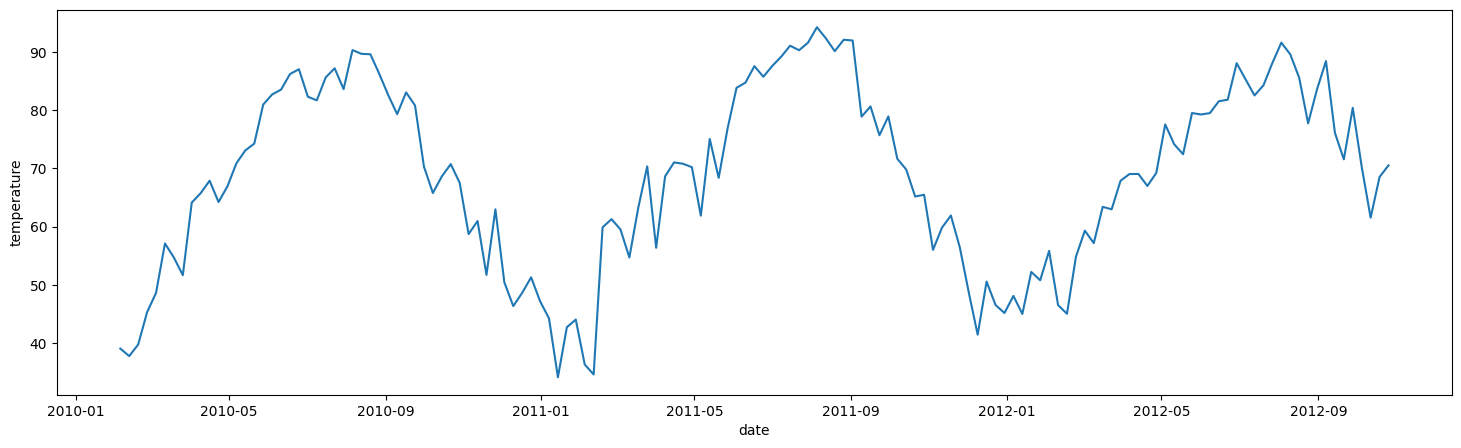

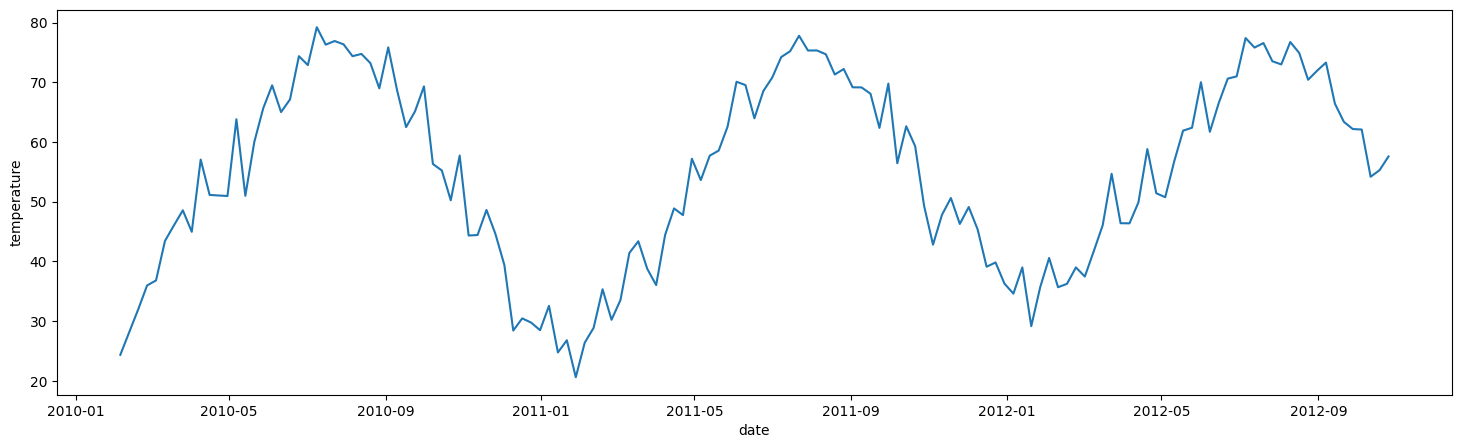

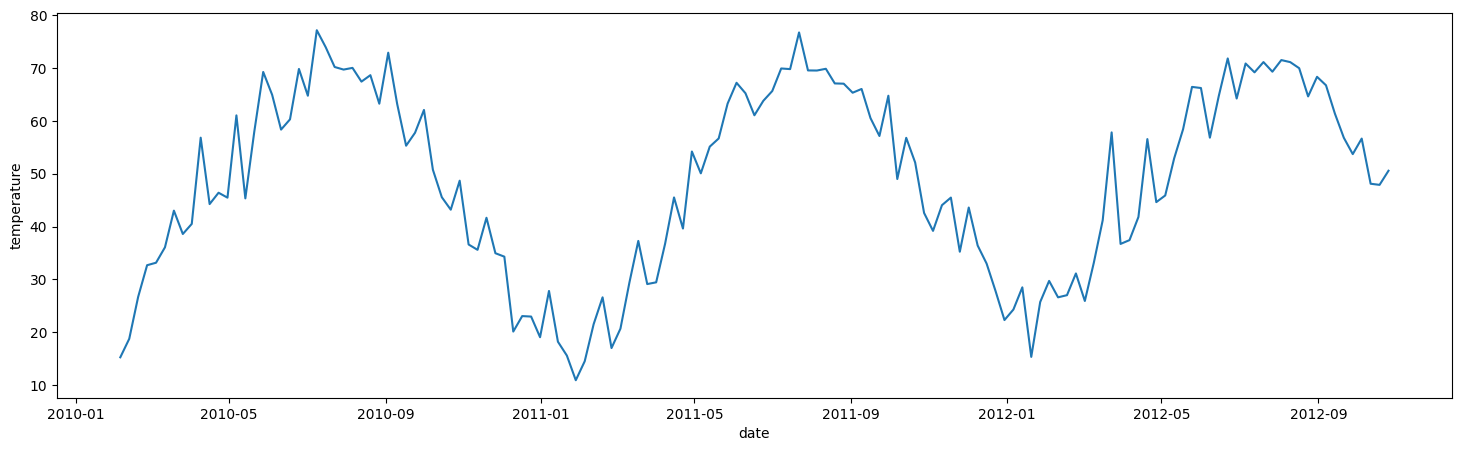

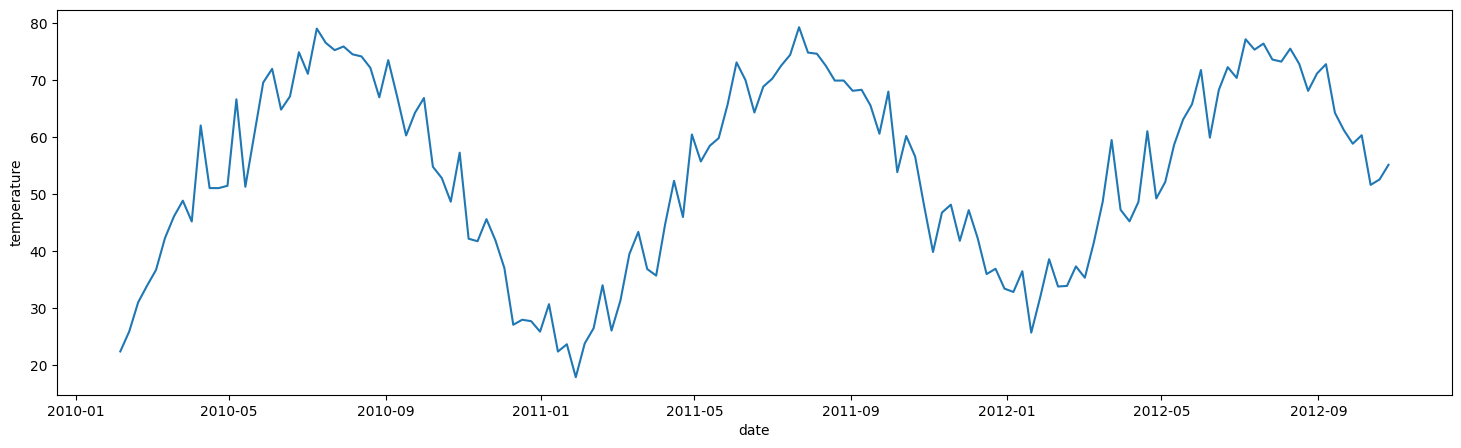

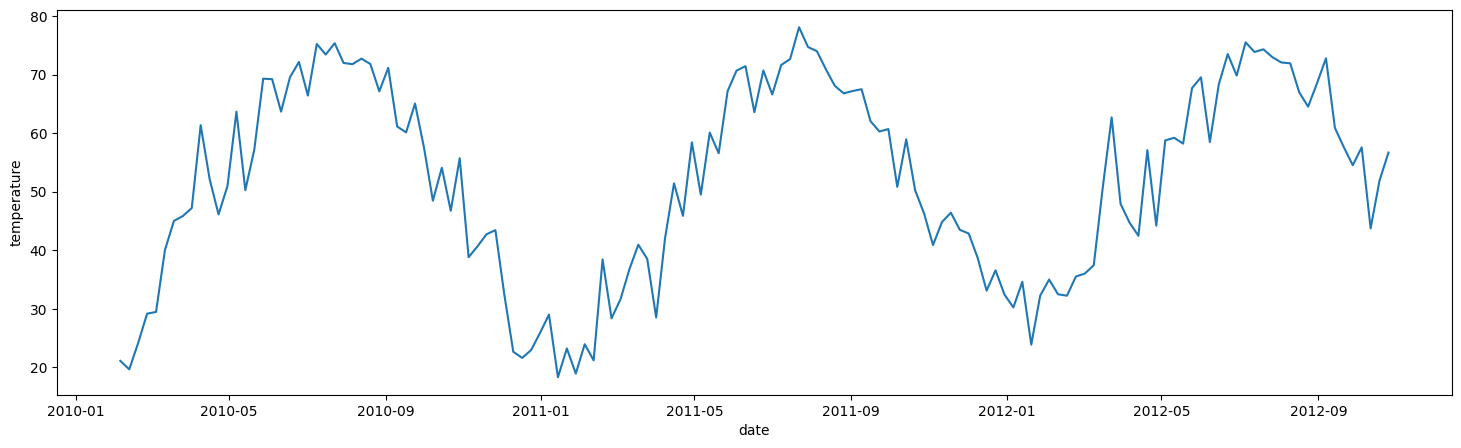

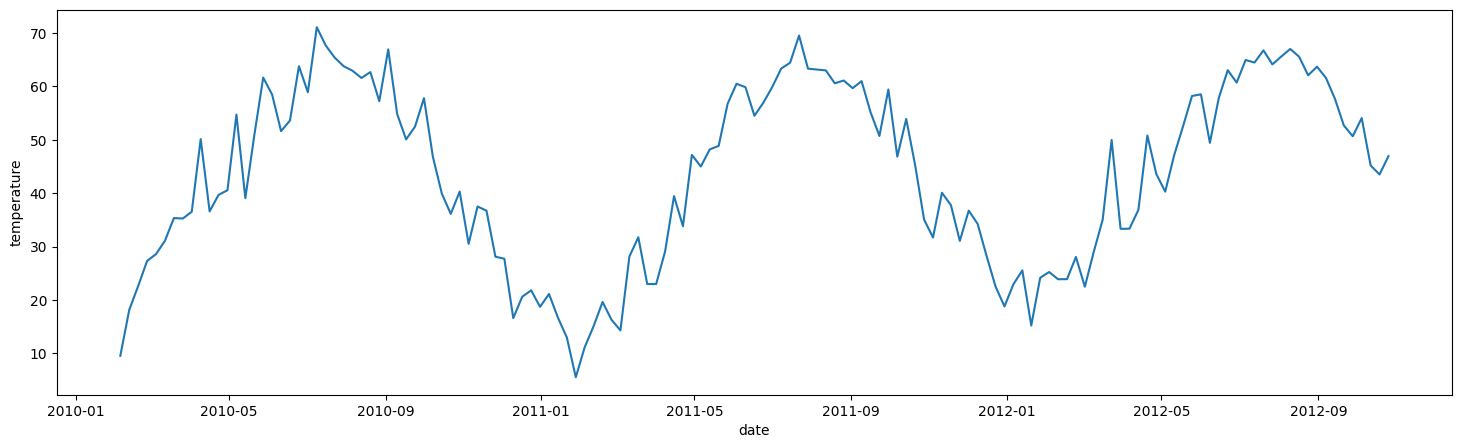

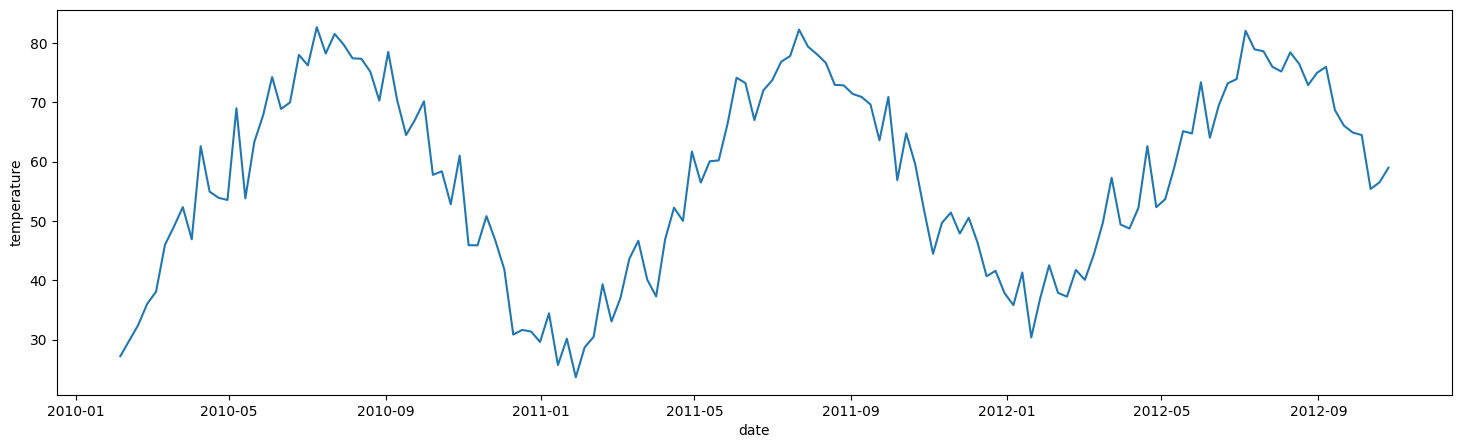

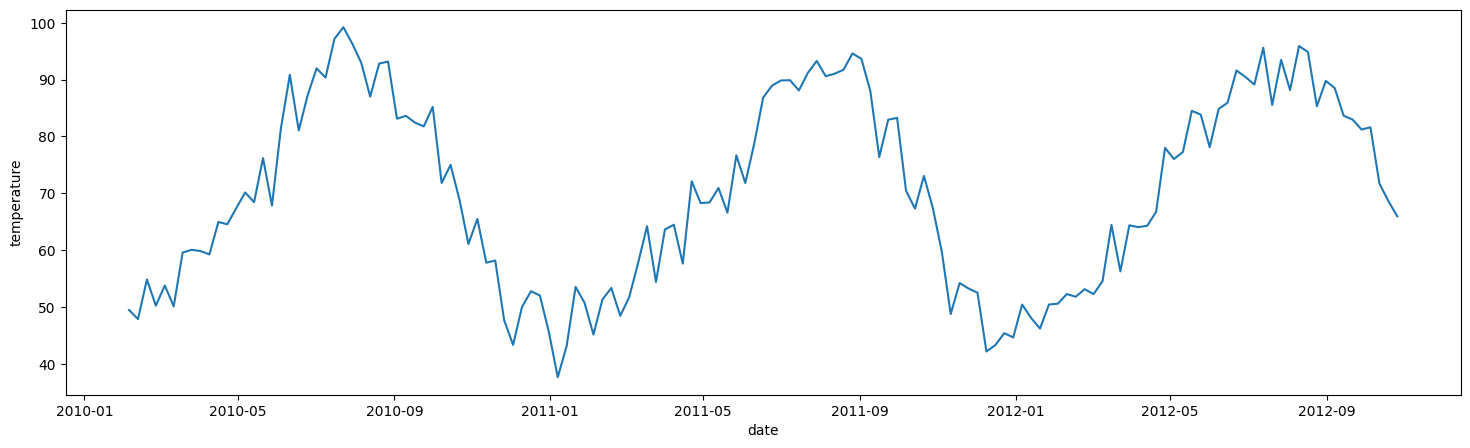

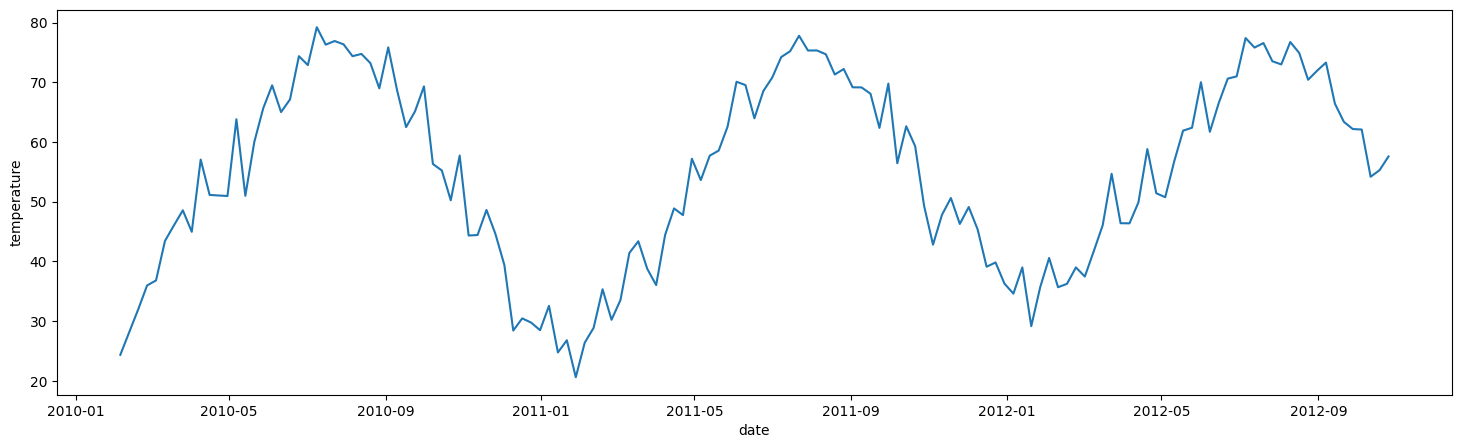

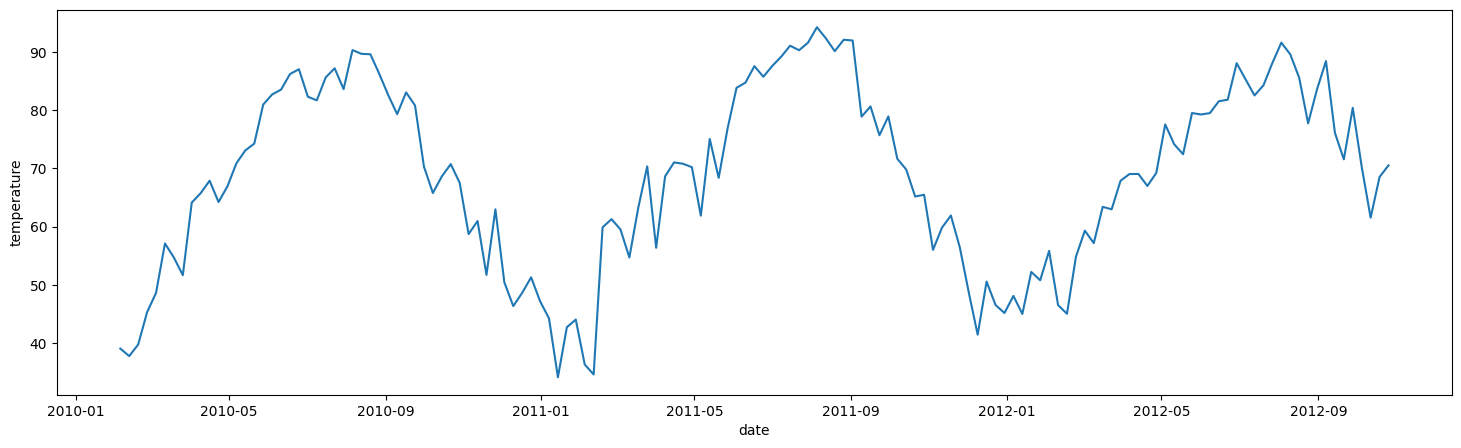

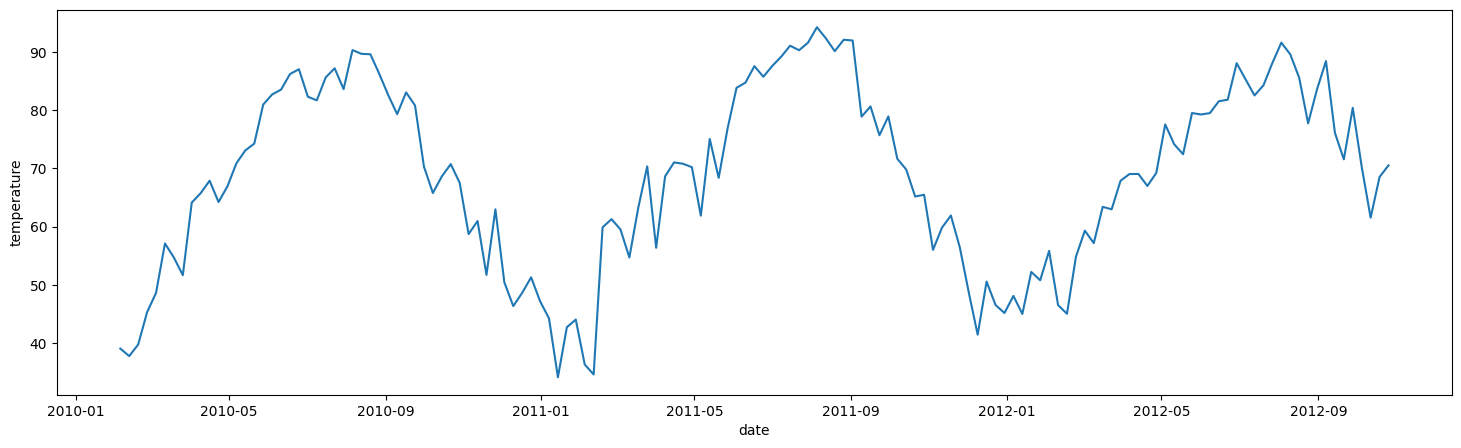

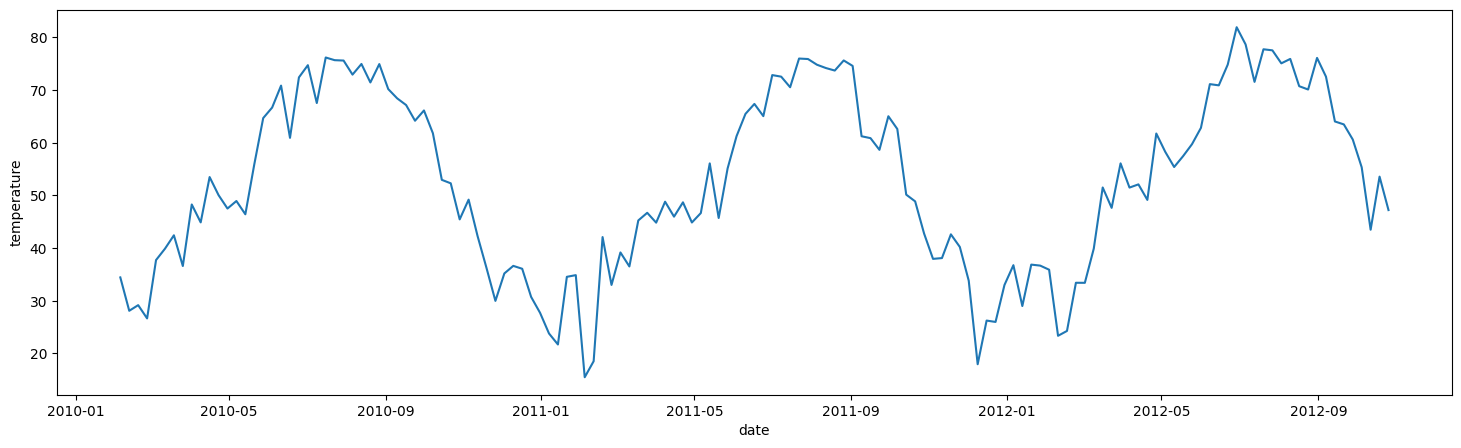

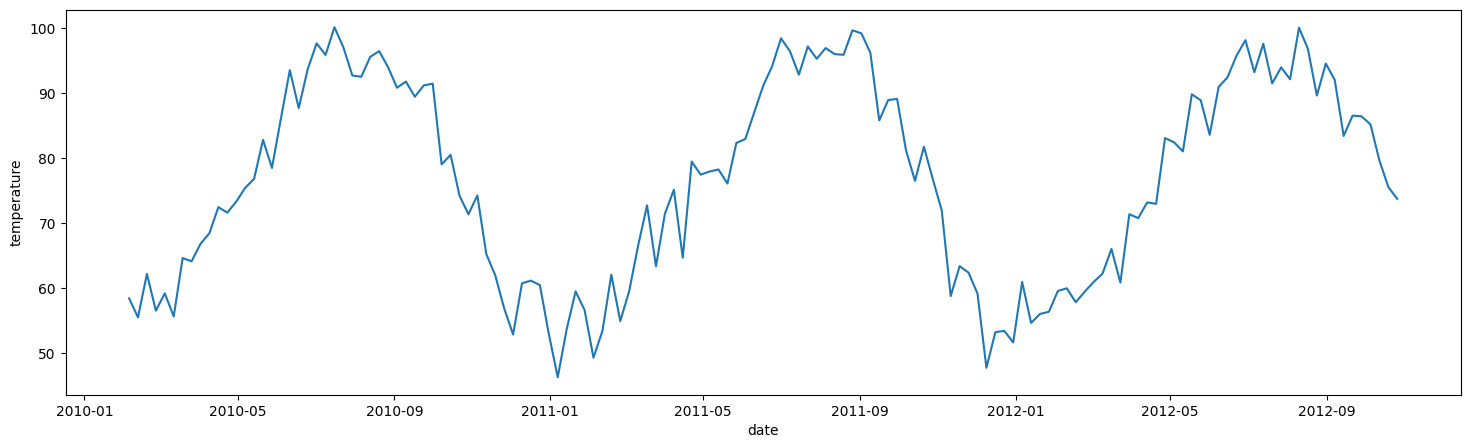

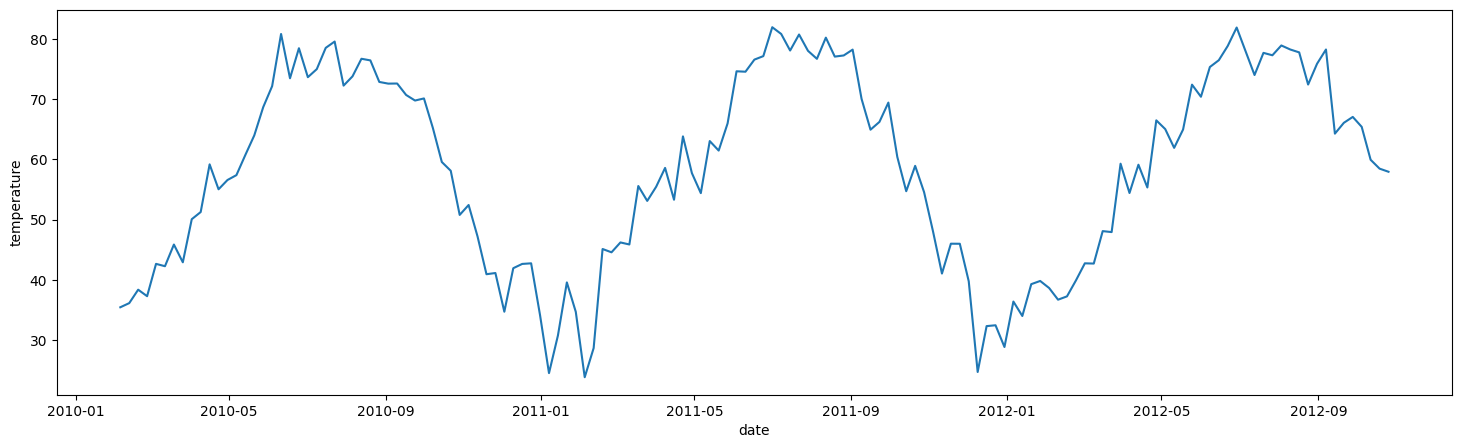

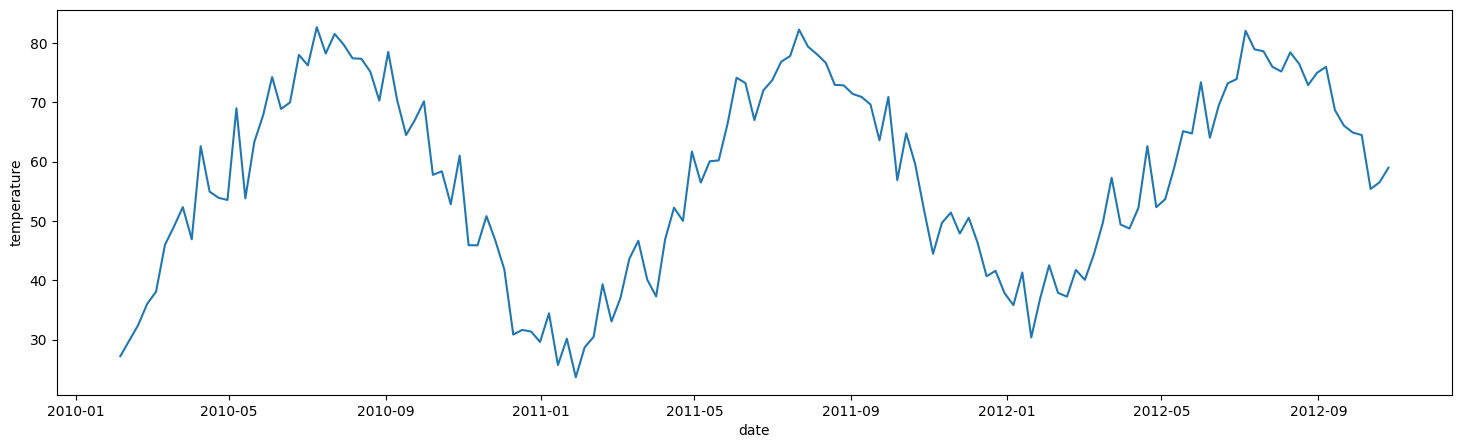

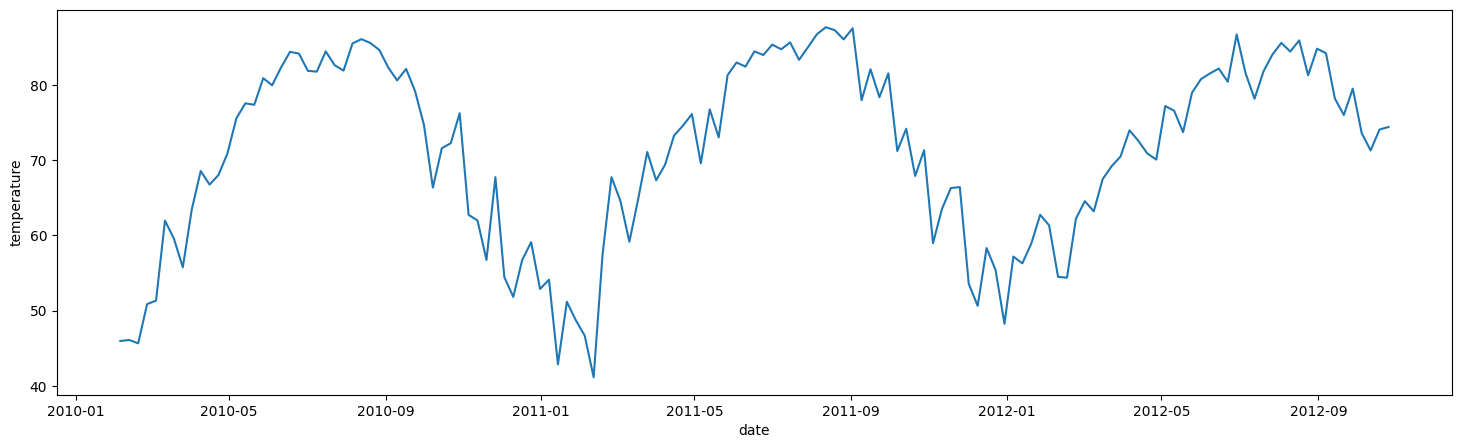

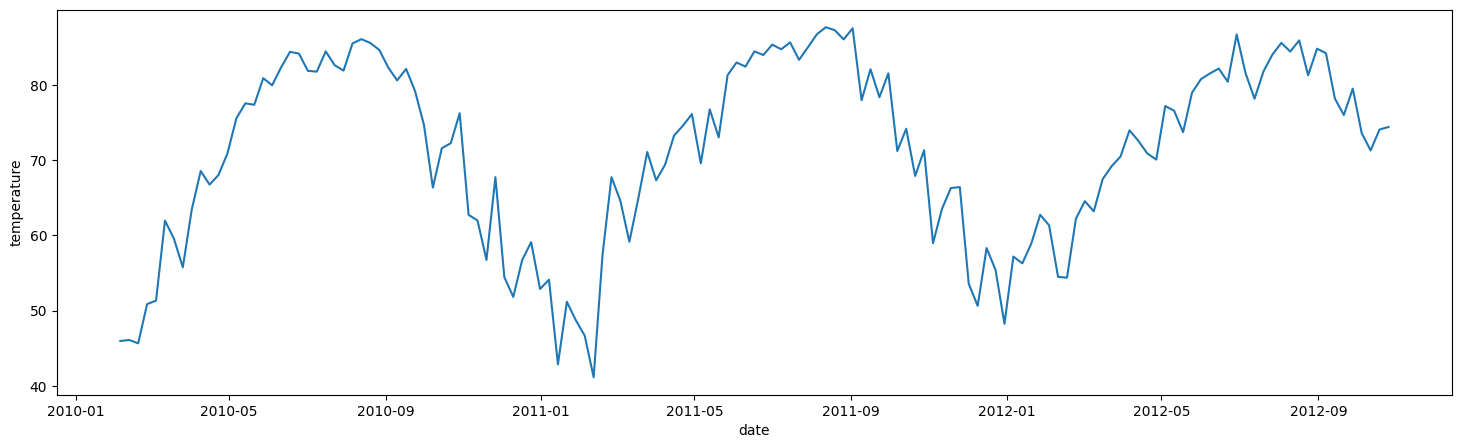

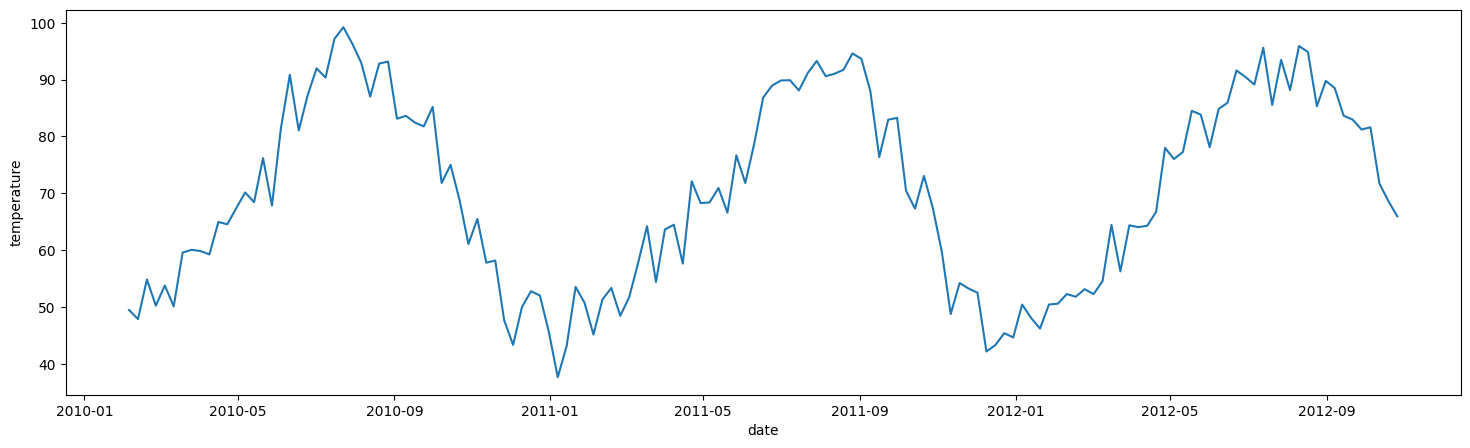

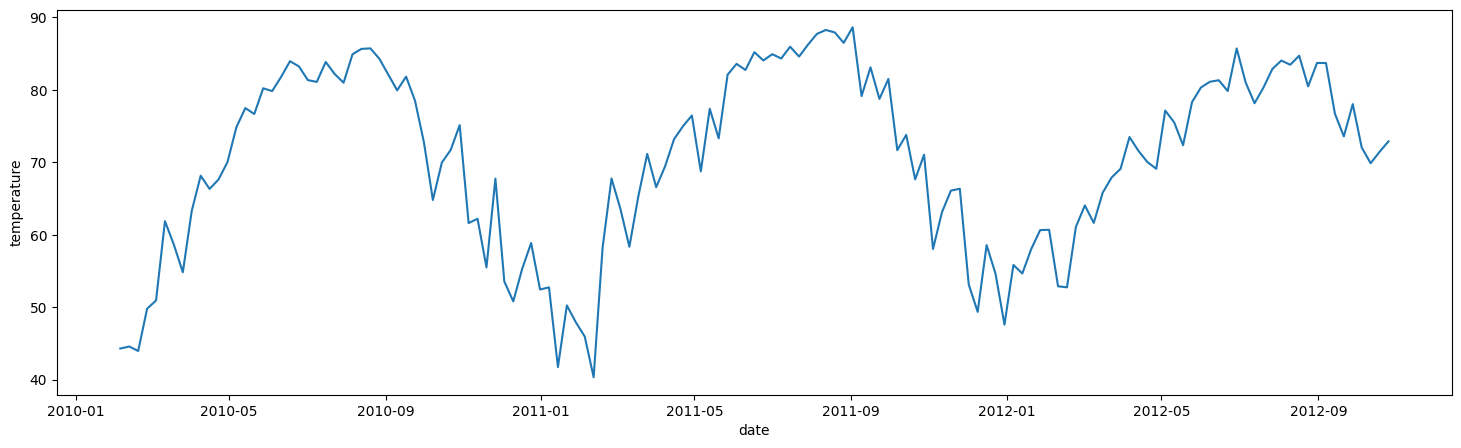

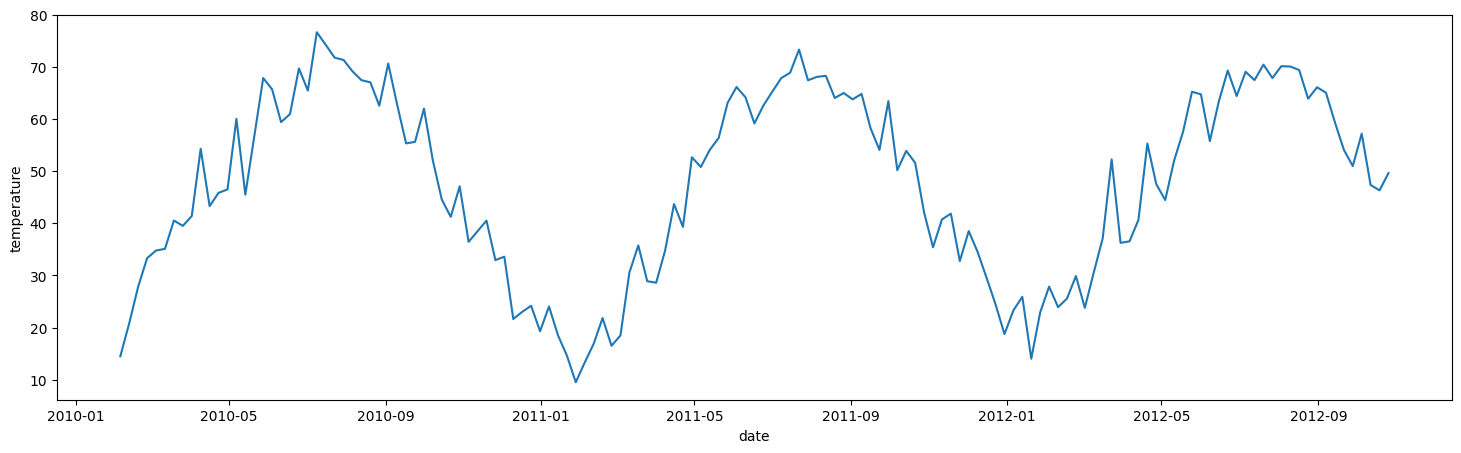

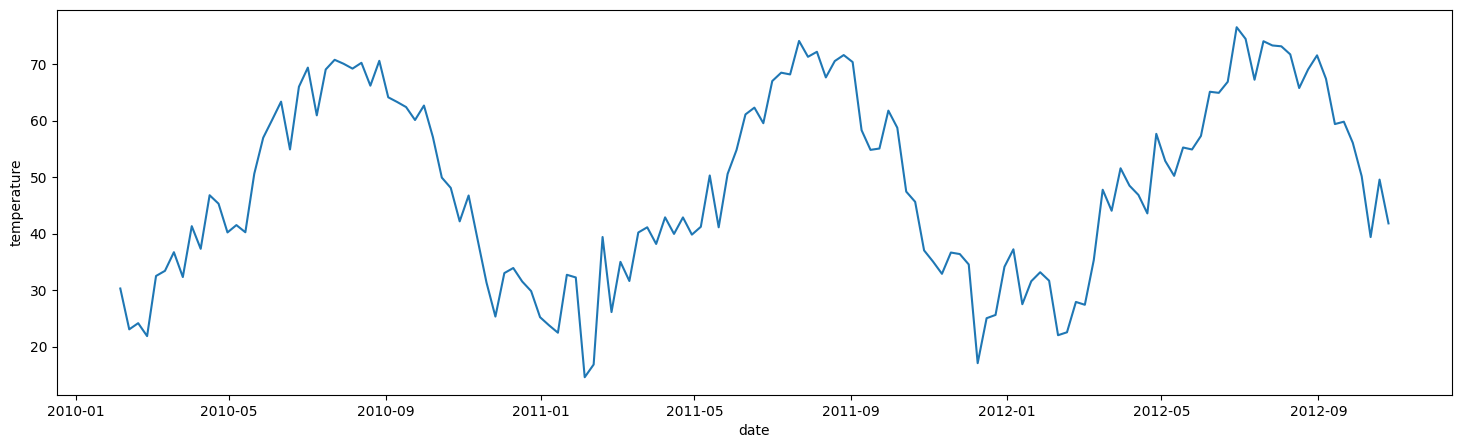

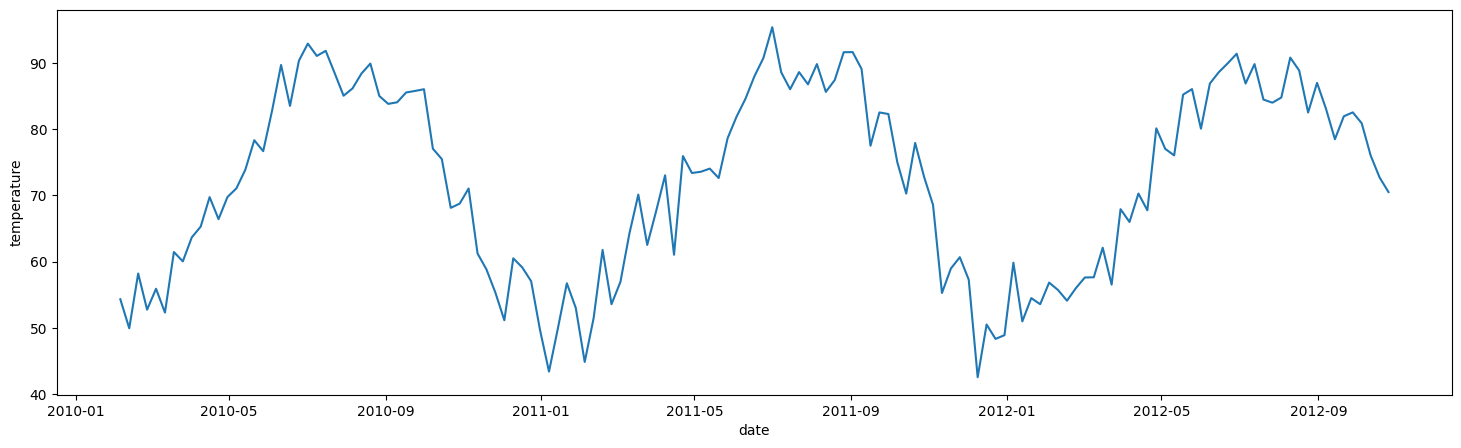

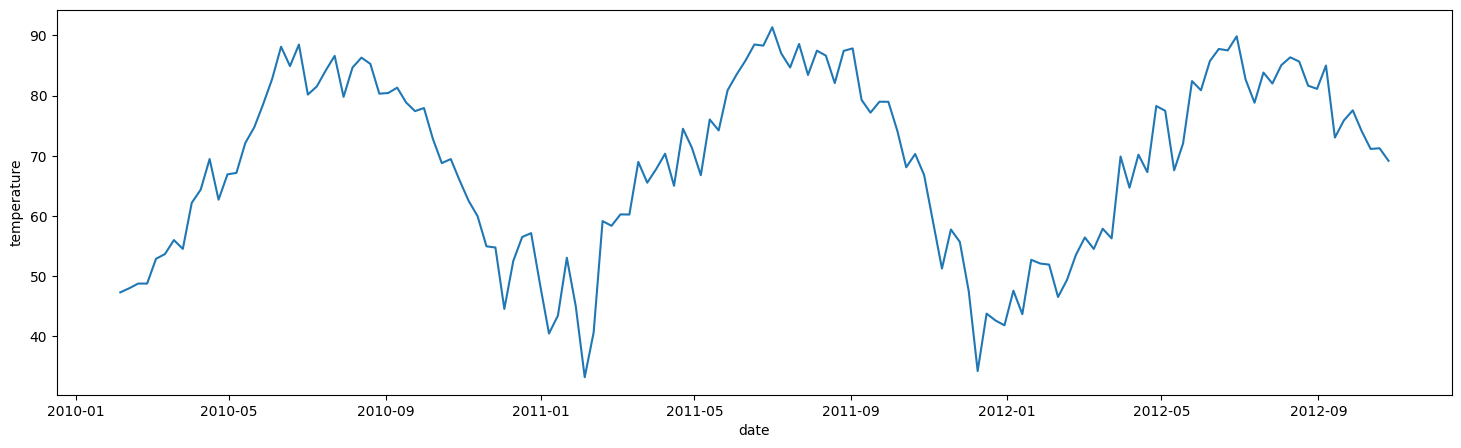

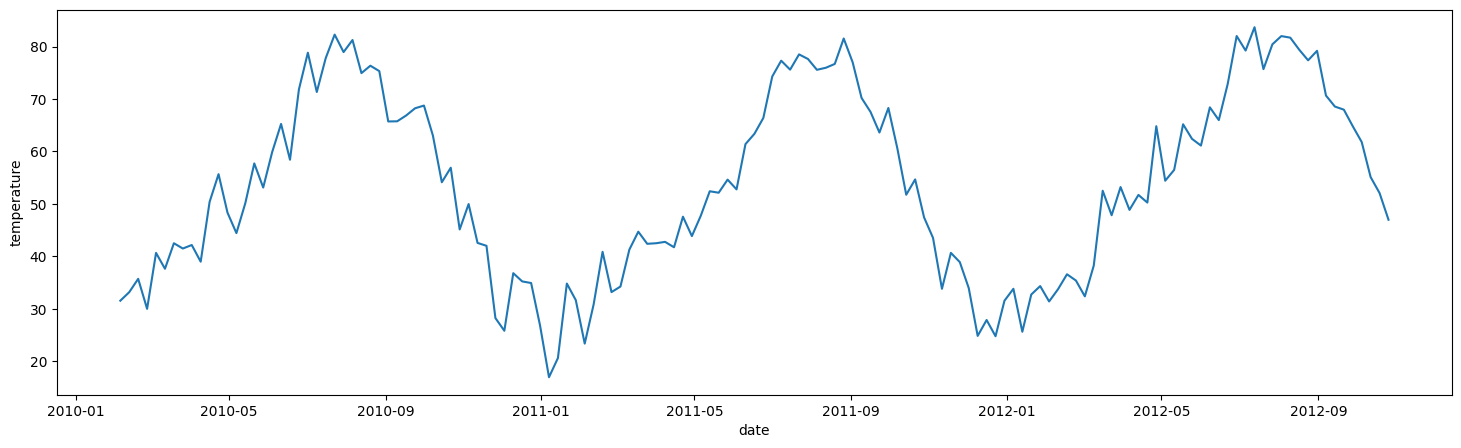

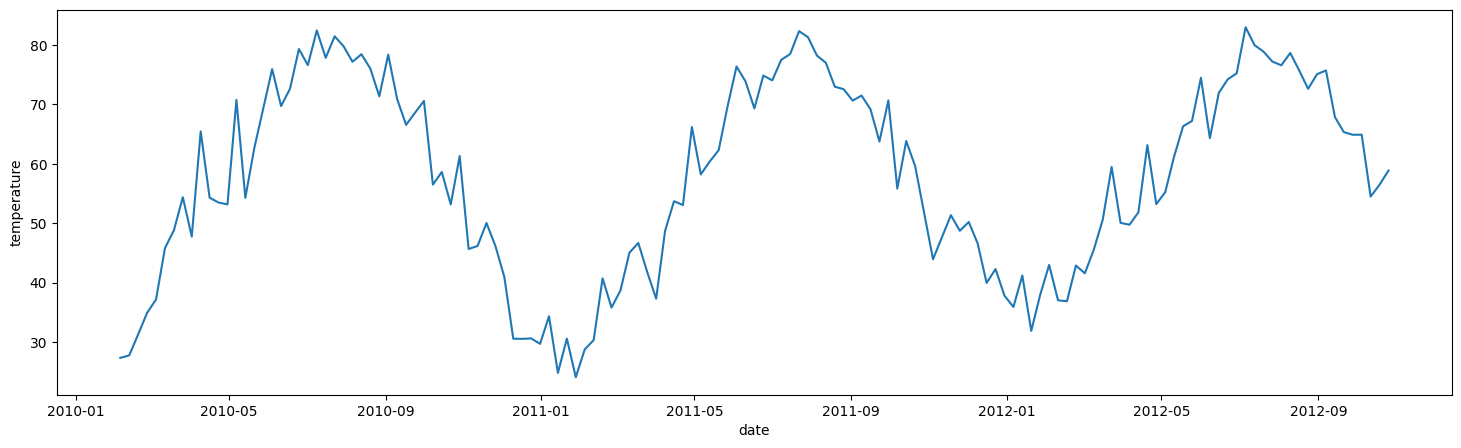

In [114]:
# temperature fluctuation differ by store
for s in df['store'].unique():
    temp_df = df[df['store'] == s][['temperature', 'date']]
    plt.figure(figsize=(18, 5))
    sns.lineplot(x = 'date', y = 'temperature', data = temp_df)

<Axes: xlabel='date', ylabel='cpi'>

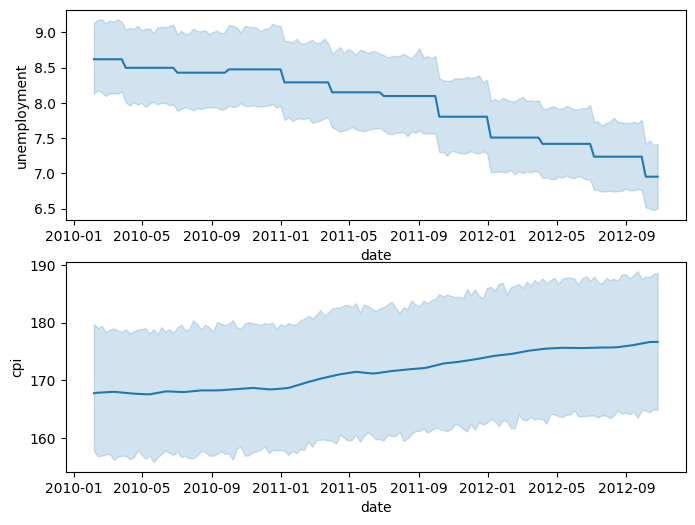

In [115]:
# unemployment rate & CPI
# Creating the figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

sns.lineplot(x='date', y='unemployment', data=df, ax=ax1)
sns.lineplot(x='date', y='cpi', data=df, ax=ax2)

<Axes: xlabel='store', ylabel='weekly_sales'>

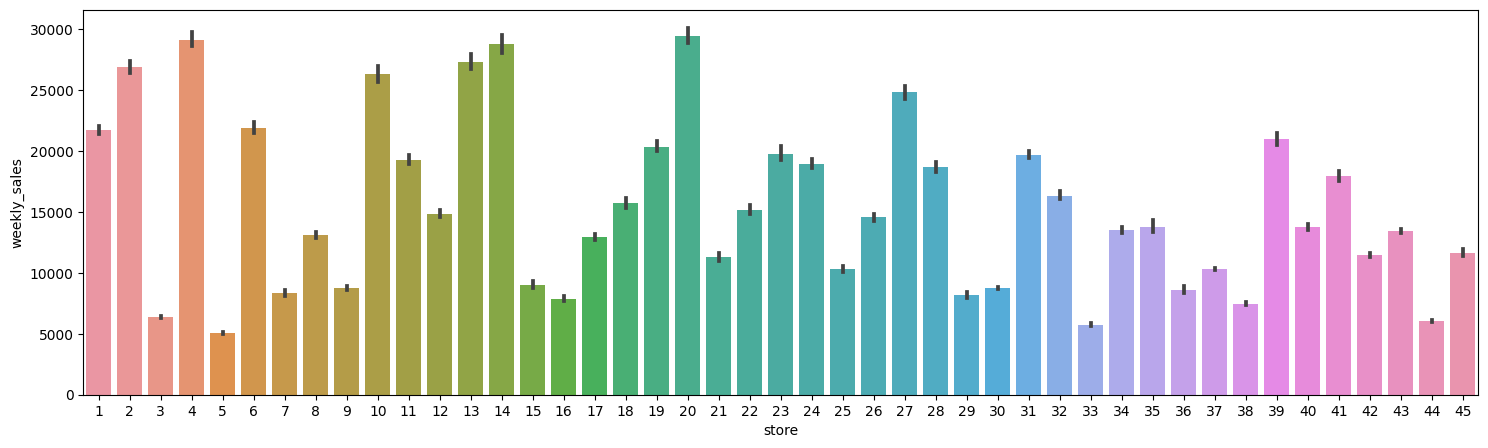

In [116]:
plt.figure(figsize=(18, 5))
sns.barplot(x = 'store', y = 'weekly_sales', data = df)

In [117]:
# weekly_sales difference according to holiday 
df.groupby('isholiday')['weekly_sales'].mean()

isholiday
False    15364.421743
True     16419.964037
Name: weekly_sales, dtype: float64

<Axes: xlabel='date', ylabel='weekly_sales'>

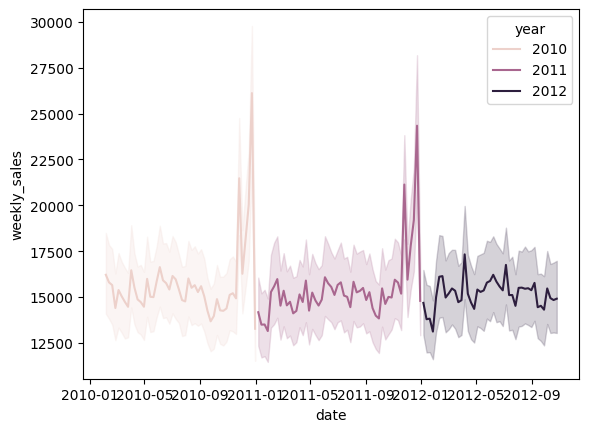

In [118]:
# weekly sales by each year
sns.lineplot(df, x = 'date', y ='weekly_sales', hue = 'year')

<Axes: xlabel='month'>

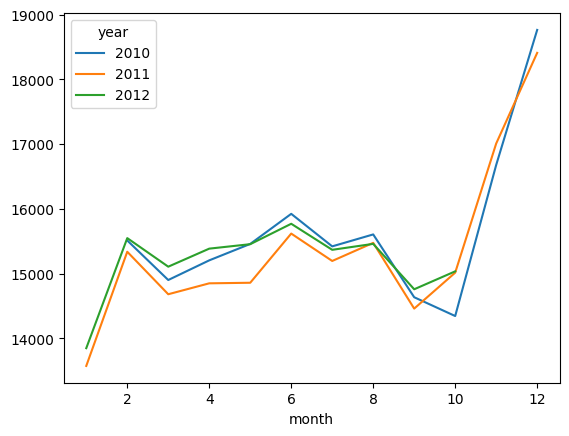

In [119]:
# monthly sales by year
temp = pd.pivot_table(df, values = 'weekly_sales', index = 'month', columns = 'year')
temp.plot()

<Axes: xlabel='month', ylabel='weekly_sales'>

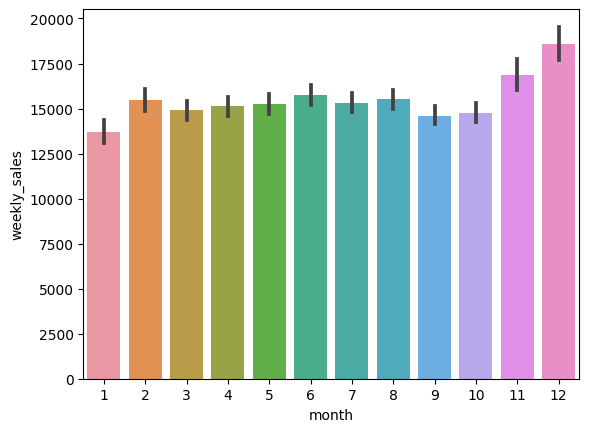

In [120]:
# time plot for monthly sales
sns.barplot(df, x = 'month', y ='weekly_sales')

#### <a id='toc1_1_1_5_'></a>[**Step 4: Feature Engineering**](#toc0_)

In [121]:
# encode categorical values
df['type'].replace({'A':1, 'B':2, 'C':3}, inplace = True)

df['isholiday'] = df['isholiday'].astype(int)
df['super_bowl'] = df['super_bowl'].astype(int)
df['labor_day'] = df['labor_day'].astype(int)
df['thanksgiving'] = df['thanksgiving'].astype(int)
df['christmas'] = df['christmas'].astype(int)

<Axes: >

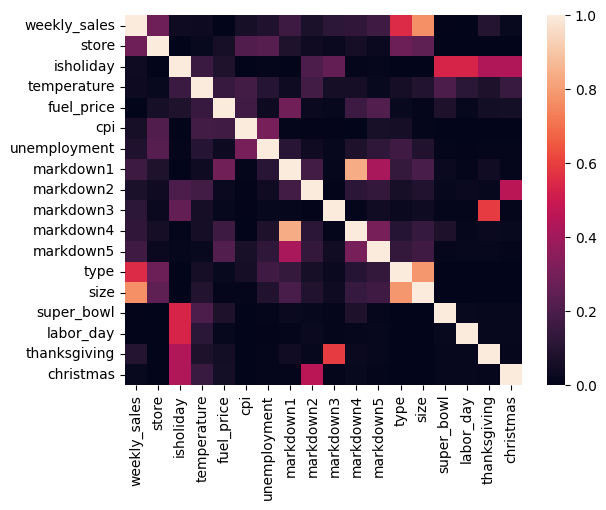

In [122]:
# explore features related to weekly_sales
df_int = df[['weekly_sales', 'store','isholiday', 'temperature',
            'fuel_price', 'cpi', 'unemployment', 'markdown1', 'markdown2', 
            'markdown3', 'markdown4', 'markdown5','type', 'size', 
            'super_bowl', 'labor_day', 'thanksgiving', 'christmas']]
sns.heatmap(df_int.corr().abs())

#### <a id='toc1_1_1_6_'></a>[**Step 5: Predictive Models**](#toc0_)

In [257]:
# extract dataset to work with
df_v1 = df[['store', 'date', 'size', 'isholiday', 'temperature', 'cpi', 'unemployment', 
            'labor_day', 'thanksgiving', 'christmas', 'super_bowl', 'weekly_sales', 'markdown1']]

In [258]:
# sort the DataFrame by the time column 
df_v1.sort_values('date', inplace = True)

In [259]:
# train-test data split
# set test_size and get the index to split data
test_size = 0.2 
split_index = int(len(df) * (1 - test_size))

df_v1.drop(columns = 'date', inplace = True)
X = df_v1.drop(columns = ['weekly_sales'])
y = df_v1['weekly_sales']

# split the data into training and test sets
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [158]:
# Evaluation criteria provided by walmart kaggle competition & mape
def wmae_test(test, pred): # WMAE for test 
    weights = X_test['isholiday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

def mape(test, pred):
    mape = np.mean(np.abs((test - pred)/test)) * 100
    return mape

##### <a id='toc1_1_1_6_1_'></a>[SARIMAX](#toc0_)

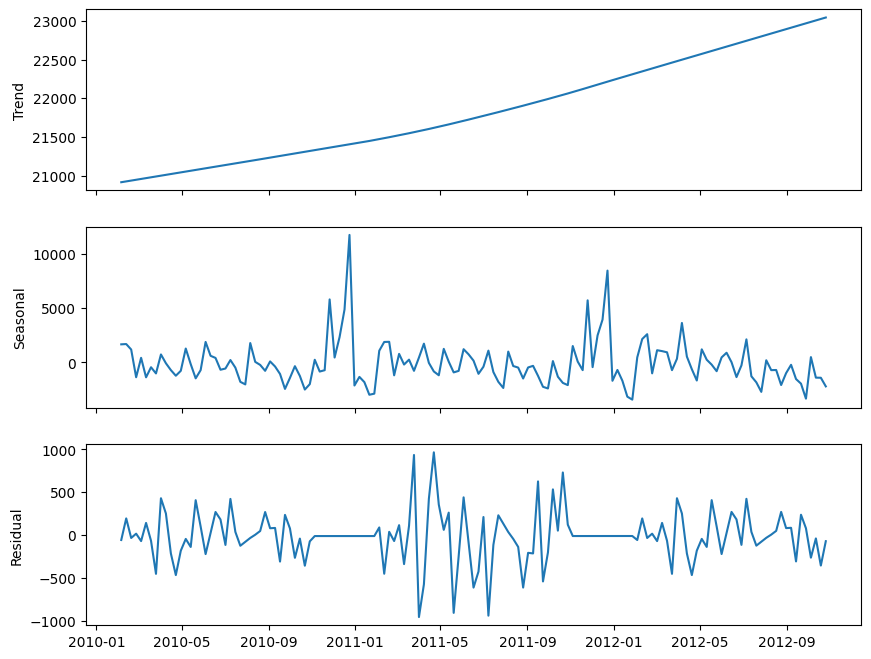

In [ ]:
# seasonal decomposition - for store 1

sales_df = df.loc[df['store'] == 1, ['date', 'weekly_sales']]
sales_df['date'] = pd.to_datetime(sales_df['date'])
sales_df.set_index('date', inplace= True)
sales_df.sort_index(inplace = True)

from statsmodels.tsa.seasonal import STL
decomposition = STL(sales_df['weekly_sales'], period=52).fit()

# Access the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,8)) 

ax1.plot(trend)
ax1.set_ylabel('Trend')
ax2.plot(seasonal)
ax2.set_ylabel('Seasonal')
ax3.plot(residual)
ax3.set_ylabel('Residual')

plt.show()

In [ ]:
# adfuller test
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

target = df_v1['weekly_sales']
ad_fuller_result = adfuller(target)
print('ADF Statistic:', ad_fuller_result[0])
print('p-value:', ad_fuller_result[1])

ADF Statistic: -13.64848648006337
p-value: 1.6025810566835743e-25


In [ ]:
# SARIMAX model - find the optimal order
p = range(0,4,1)
d = 1
q = range(0,4,1)
P = range(0,4,1)
D = 0
Q = range(0,4,1)
s = 4

In [53]:
from itertools import product

parameters = product(p,q,P,Q)
parameters_list = list(parameters)

In [54]:
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMAX(endog, exog, order_list, d, D, s):
    
    results = []

    for order in order_list:
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order = (order[2], D, order[3], s),
                simple_differencing= False
            ).fit(disp = False)
        except:
            continue
    
    aic = model.aic
    results.append([order, aic])

    results_df = pd.DataFrame(results)
    results_df.columns = ['(p,q,P,Q)', 'AIC']

    results_df = results_df.sort_values(by = 'AIC').reset_index(drop = True)

    return results_df

In [55]:
# select data for training
target_train = target[:200] 
exog = df_v1['isholiday']
exog_train = exog[:200]
results_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
results_df

In [58]:
# fit the best model
best_model = SARIMAX(target_train, exog_train, order = (3, 1, 3),
                     seasonal_order= (3,0,3,4), simple_differencing= False)
best_model_fit = best_model.fit()

best_model_fit

lb_pvalue


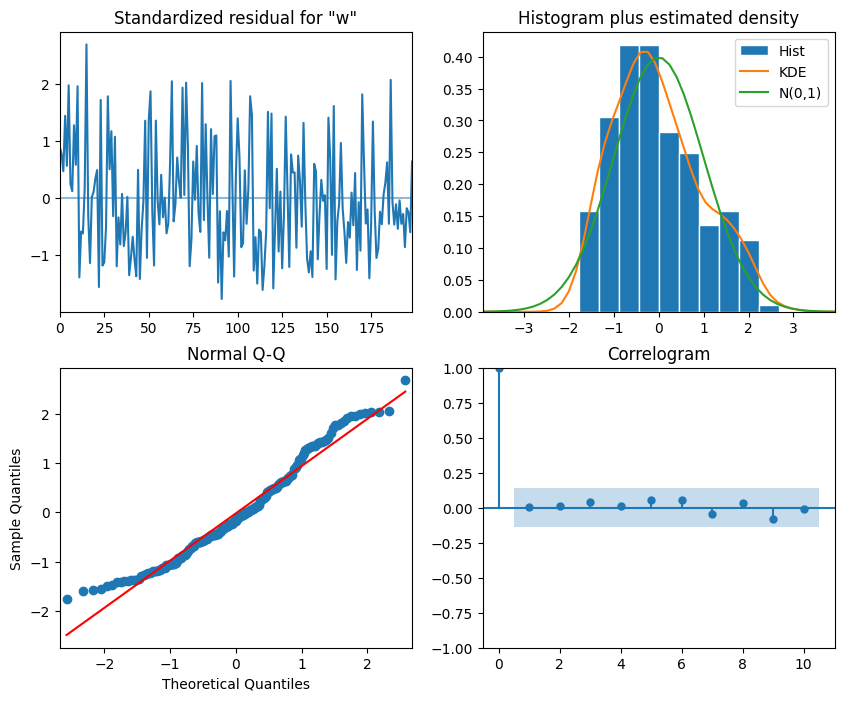

In [59]:
# Residual Analysis
from statsmodels.stats.diagnostic import acorr_ljungbox

best_model_fit.plot_diagnostics(figsize = (10, 8))
residuals = best_model_fit.resid
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(pvalue)

In [60]:
def recursive_forecast(endog, exog, train_len, horizon, window, method):

    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []

        for i in range(train_len, total_len, window):
            
            model = SARIMAX(endog[:i], exog[:i], order = (3, 1, 3),
            seasonal_order= (3,0,3,4), simple_differencing= False)
            res = model.fit(disp = False)
            predictions = res.get_prediction(exog = exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [77]:
exog = exog.apply(lambda x: 1 if x else 0)

In [80]:
# # Recursive Forecasting

target_train = target[:4000]
target_test = target[4000:]
pred_df = pd.DataFrame({'actual':target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_sarimax'] = pred_SARIMAX

# Evaluation using Mean Absolute Percent Error (MAPE)

mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print('Naive Last Value: ', mape_last, 'SARIMAX Value: ', mape_SARIMAX)

##### <a id='toc1_1_1_6_2_'></a>[SARIMAX with auto_arima](#toc0_)

In [91]:
from pmdarima import auto_arima
df= pd.DataFrame(columns=['store','date','predictions'])

# Predict for 45 Stores
for i in range(1, 46):

    # extract store i data 
    store_df = df_v1.loc[df_v1['store'] == i, ['weekly_sales', 'isholiday', 'cpi']]
    s_exog = store_df[['isholiday', 'cpi']]

    # train test split
    test_week = 30
    test_df = store_df.iloc[-test_week:, :]

    s_exog_train = s_exog.iloc[:-test_week, :]
    s_exog_test = s_exog.iloc[-test_week:, :]

    # fit model 
    model = auto_arima(y = store_df['weekly_sales'],
                       x = s_exog_train,
                       m = 52, 
                       seasonal = True,
                       stepwise = True)
    
    # predict 
    predictions = pd.Series(model.predict(n_periods = test_week,
                                X = test_df[['isholiday', 'cpi']])).rename('predictions')
    sarima_df = predictions.to_frame()
    sarima_df = sarima_df.reset_index()
    sarima_df['store'] = i
    df.append(sarima_df)

    # check loop
    print('store {} finished'.format(i))

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
# Evaluations
df_act = df_v1[['store', 'date', 'weekly_sales']]
df_final = pd.merge([df, df_act], on = ['store', 'date'])

mape(df_final['weekly_sales'], df_final['predictions'])

##### <a id='toc1_1_1_6_3_'></a>[Random Forest Regressor](#toc0_)

In [147]:
# baseline random forest model 
model = RandomForestRegressor(n_estimators = 100, random_state= 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# wmae 
rf_val_wmae = wmae_test(y_pred, y_test)
rf_val_mape = mape(y_pred, y_test)
print('The WMAE for the validation set: {}'.format(rf_val_wmae))
print('MAPE for the validation set: {}'.format(rf_val_mape))

The WMAE for the validation set: 1898.7926405662447
MAPE for the validation set: 8.814186966673144


In [82]:
# calculate feature importance to extract new training dataset
imp_df = pd.DataFrame({'feature':model.feature_names_in_,
            'imp':model.feature_impotances}).sort_value('imp')

array(['store', 'size', 'isholiday', 'temperature', 'cpi', 'unemployment',
       'labor_day', 'thanksgiving', 'christmas', 'super_bowl',
       'markdown1'], dtype=object)

In [184]:
# function to tune parameters
def test_rf_models(**params):
    model = RandomForestRegressor(**params).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # rf_val_wmae = wmae_test(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred)/y_test)) * 100
    
    return mape

def plot_rf(param_name, param_values):
    errors = []

    for value in param_values:
        params = {param_name: value}
        error = test_rf_models(**params)
        errors.append(error)

    plt.plot(param_values, errors)
    plt.xlabel(param_name)
    plt.ylabel('MAPE')

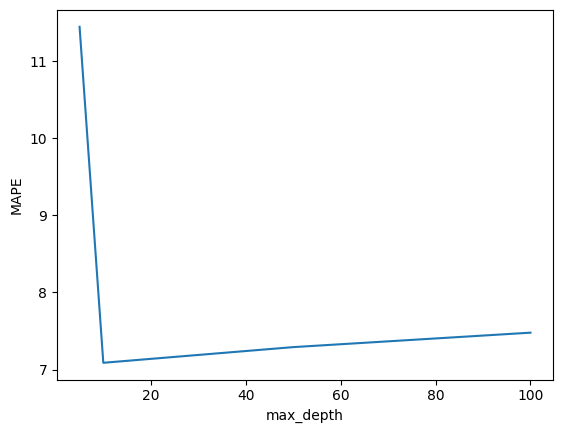

In [185]:
# wmae according to max_depth

plot_rf('max_depth', [5, 10, 50, 100])

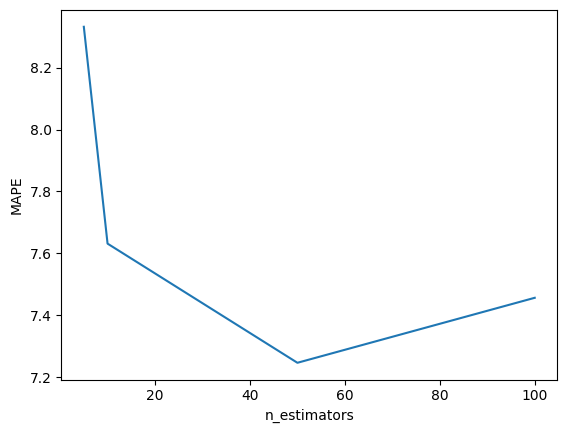

In [186]:
plot_rf('n_estimators', [5, 10, 50, 100])

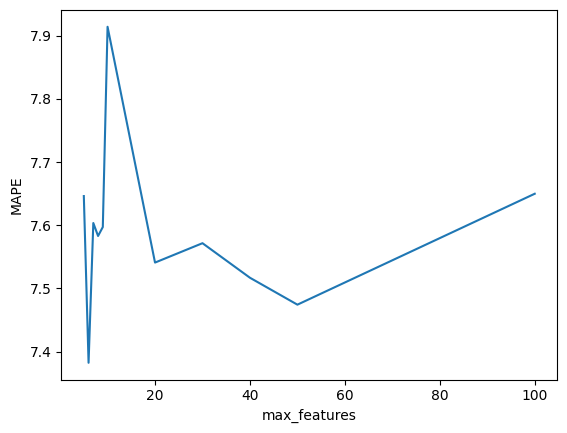

In [198]:
plot_rf('max_features', [5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100])

In [135]:
# tuned random forest regressor
rf = RandomForestRegressor(max_depth = 10, max_features = 'sqrt', n_estimators = 50)
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [194]:
# random forest regressor for each store
# Predict for 45 Stores
eval = []
for i in range(1, 46):

    # extract store i data 
    store_df = df_v1[df_v1['store'] == i]

    # train test split
    test_week = 50
    test_df = store_df.iloc[test_week:]
    train_df = store_df.iloc[:test_week]

    X_train = train_df.drop(columns = 'weekly_sales')
    y_train = train_df['weekly_sales']
    X_test = test_df.drop(columns = 'weekly_sales')
    y_test = list(test_df['weekly_sales'])

    # fit model 
    model = RandomForestRegressor(n_estimators= 50, max_depth = 10, max_features = 'sqrt')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # evaluation
    mape = np.mean(np.abs(y_test - y_pred)/y_test) * 100
    eval.append(mape)

    # check loop
    print('store {} finished'.format(i))
    print(mape)

store 1 finished
7.78774569649886
store 2 finished
5.219231155393801
store 3 finished
9.111155573759037
store 4 finished
5.924511677275533
store 5 finished
7.149144769994291
store 6 finished
7.8805090870171846
store 7 finished
14.637115087911774
store 8 finished
5.608685400718414
store 9 finished
6.020445606888049
store 10 finished
20.170559887376672
store 11 finished
5.734917575486122
store 12 finished
8.659686791557322
store 13 finished
12.293231757280552
store 14 finished
9.981910927864531
store 15 finished
11.59943384477353
store 16 finished
15.485033266227195
store 17 finished
8.400425607062484
store 18 finished
8.040817418273333
store 19 finished
7.9962306499860105
store 20 finished
6.595636314027856
store 21 finished
8.239297045142893
store 22 finished
7.109106371683252
store 23 finished
13.283163096207762
store 24 finished
6.284253323031487
store 25 finished
9.02731319202343
store 26 finished
7.79719962013009
store 27 finished
7.715270309553321
store 28 finished
8.7472977896257

In [195]:
# average mape and wmae across 45 stores 
np.mean(eval)

9.244031916316905

##### <a id='toc1_1_1_6_4_'></a>[Prophet](#toc0_)

In [226]:
df_v1['date']

dtype('<M8[ns]')

In [232]:
y_test = test_df['y']
y_test.reset_index(drop = True)

0      11427.595970
1      10805.788806
2      17389.708235
3      12930.072059
4      14960.661791
           ...     
98     10805.665909
99     10786.103971
100    11128.247879
101    10880.689848
102    11347.484030
Name: y, Length: 103, dtype: float64

In [239]:
from prophet import Prophet
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

eval = []
for i in range(1, 46):

    # extract dataframe 
    df_v1.sort_values('date', inplace = True)
    df_p = df_v1.loc[df_v1['store'] == i, ['date','weekly_sales']]
    df_p.columns = ['ds', 'y']

    # train_test_split 
    test_weeks = 40
    train_df = df_p.iloc[:test_weeks]
    test_df = df_p.iloc[test_weeks:]
    y_test = test_df['y']
    y_test = y_test.reset_index(drop=True)

    # prophet 
    model = Prophet()
    model.fit(train_df)

    # make predictions
    future = model.make_future_dataframe(periods = 40)
    forecast = model.predict(future)
    y_pred = forecast['yhat']
    mape = np.mean(np.abs((y_test - y_pred)/y_test)) * 100
    eval.append(mape)

In [241]:
# average mape value across 45 stores
np.mean(eval)

10.783498926775986

In [255]:
# tune prophet model
from sklearn.model_selection import ParameterGrid

param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all possible combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))

# Perform grid search with cross-validation
best_mape = np.inf
best_params = None

for params in param_combinations:

    mape_list = []
    for i in range(1, 46):

        # extract dataframe 
        df_v1.sort_values('date', inplace = True)
        df_p = df_v1.loc[df_v1['store'] == i, ['date','weekly_sales']]
        df_p.columns = ['ds', 'y']

         # train_test_split 
        test_weeks = 40
        train_df = df_p.iloc[:test_weeks]
        test_df = df_p.iloc[test_weeks:]
        y_test = test_df['y']
        y_test = y_test.reset_index(drop=True)

        # prophet 
        model = Prophet(**params)
        model.fit(train_df)

        # make predictions
        future = model.make_future_dataframe(periods = 40)
        forecast = model.predict(future)
        y_pred = forecast['yhat']
        mape = np.mean(np.abs((y_test - y_pred)/y_test)) * 100
        mape_list.append(mape)
    
    mape = np.mean(mape_list)
    if mape < best_mape:
        best_mape = mape
        best_params = params

print("Best MAPE:", best_mape)
print("Best Hyperparameters:", best_params)

Best MAPE: 10.508843420578403
Best Hyperparameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


In [254]:
from prophet import Prophet
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

eval = []
for i in range(1, 46):

    # extract dataframe 
    df_v1.sort_values('date', inplace = True)
    df_p = df_v1.loc[df_v1['store'] == i, ['date','weekly_sales']]
    df_p.columns = ['ds', 'y']

    # train_test_split 
    test_weeks = 40
    train_df = df_p.iloc[:test_weeks]
    test_df = df_p.iloc[test_weeks:]
    y_test = test_df['y']
    y_test = y_test.reset_index(drop=True)

    # prophet 
    best_params = {'changepoint_prior_scale': 0.01, 
            'holidays_prior_scale': 0.01, 
            'seasonality_mode': 'additive', 
            'seasonality_prior_scale': 0.01}
    model = Prophet(**best_params)
    model.fit(train_df)

    # make predictions
    future = model.make_future_dataframe(periods = 40)
    forecast = model.predict(future)
    y_pred = forecast['yhat']
    mape = np.mean(np.abs((y_test - y_pred)/y_test)) * 100
    eval.append(mape)

# average mape value across 45 stores
np.mean(eval)

10.508843420578403

##### <a id='toc1_1_1_6_5_'></a>[XGBoost](#toc0_)

In [262]:
from xgboost import XGBRegressor

# baseline xgb 
gbm = XGBRegressor(n_jobs = -1)
gbm.fit(X_train, y_train)
gbm_pred  = gbm.predict(X_test)

# wmae 
gbm_val_wmae = wmae_test(y_test, gbm_pred)
gbm_val_mape = np.mean(np.abs((y_test - gbm_pred)/y_test)) * 100
print('The WMAE loss for validation set: {}'.format(gbm_val_wmae))
print('The MAPE for validation set: {}'.format(gbm_val_mape))

The WMAE loss for validation set: 1491.2520627643762
The MAPE for validation set: 10.231239593858165


<Axes: xlabel='importance', ylabel='feature'>

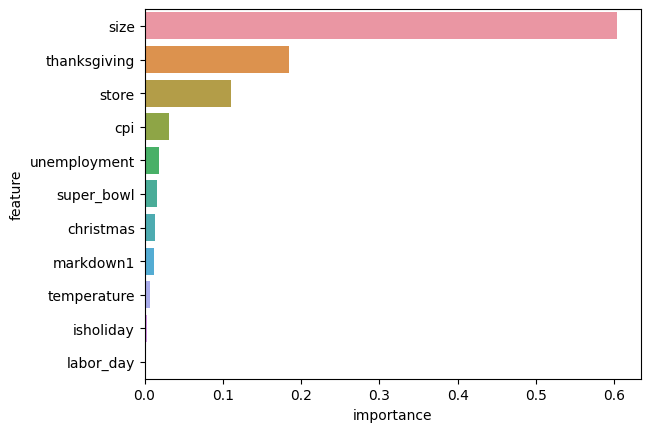

In [263]:
importance_df = pd.DataFrame({
        'feature':X_train.columns,
        'importance': gbm.feature_importances_
}).sort_values('importance', ascending= False)

sns.barplot(data = importance_df, x ='importance', y ='feature')

In [291]:
# hyperparameter tuning xgb
def test_params_xgb(**params):
    ''' 
    a function that test xgb based on multiple hyperparameters
    '''
    model = XGBRegressor(n_jobs = -1, **params).fit(X_train, y_train)
    gbm_pred = model.predict(X_test)
    val_wmae = wmae_test(gbm_pred, y_test)
    mape = np.mean(np.abs((y_test - gbm_pred)/y_test)) * 100
    return mape

def plot_xgb(param_name, param_values):

    errors = []

    for value in param_values:
        params = {param_name:value}
        val_wmae = test_params_xgb(**params)
        
        # attach errors for each parameter values 
        errors.append(val_wmae)

    # plot
    plt.plot(param_values, errors)
    plt.xlabel(param_name)
    plt.ylabel('MAPE')

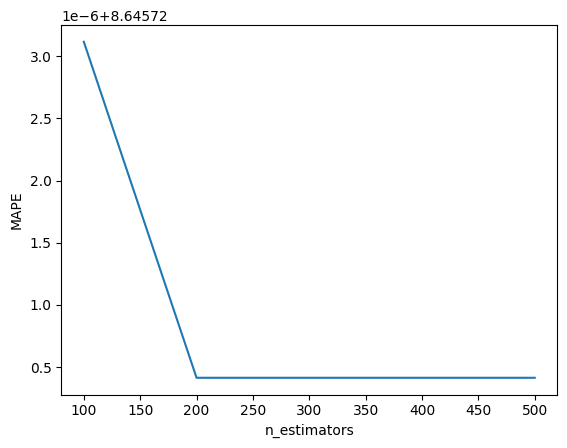

In [292]:
plot_xgb('n_estimators', [100, 200, 300, 400, 500])

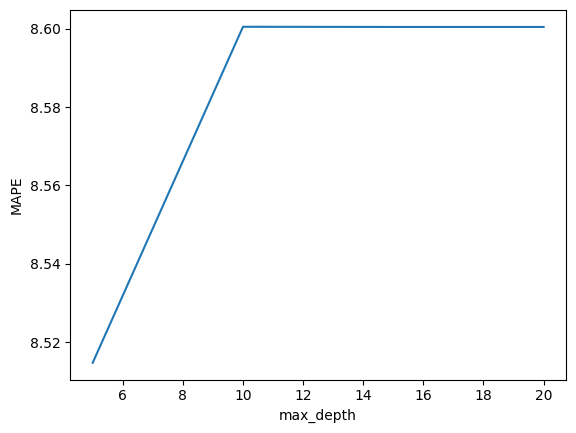

In [293]:
plot_xgb('max_depth', [5, 10, 15, 20])

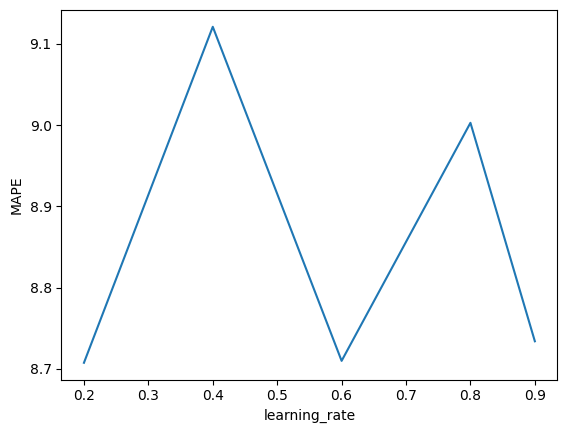

In [294]:
plot_xgb('learning_rate', [0.2, 0.4, 0.6, 0.8, 0.9])

In [273]:
# tuned xgb
gbm = XGBRegressor(n_jobs = -1, learning_rate = 0.4, max_depth = 20, n_estimators = 100)
gbm.fit(X_train, y_train)
gbm_pred  = gbm.predict(X_test)

# evaluation
gbm_val_wmae = wmae_test(y_test, gbm_pred)
gbm_val_mape = np.mean(np.abs((y_test - gbm_pred)/y_test)) * 100
print('The WMAE loss for validation set: {}'.format(gbm_val_wmae))
print('The MAPE for validation set: {}'.format(gbm_val_mape))

The WMAE loss for validation set: 1332.992122492514
The MAPE for validation set: 8.889744238277707


In [295]:
eval = []
for i in range(1, 46):

    # extract dataframe 
    store_df = df_v1[df_v1['store'] == i]

    # train test split
    test_week = 30
    test_df = store_df.iloc[test_week:]
    train_df = store_df.iloc[:test_week]

    X_train = train_df.drop(columns = 'weekly_sales')
    y_train = train_df['weekly_sales']
    X_test = test_df.drop(columns = 'weekly_sales')
    y_test = list(test_df['weekly_sales'])

    gbm = XGBRegressor(n_jobs = -1, learning_rate = 0.6, max_depth = 3, n_estimators = 200)
    gbm.fit(X_train, y_train)
    gbm_pred  = gbm.predict(X_test)

    # make predictions
    mape = np.mean(np.abs((y_test - gbm_pred)/y_test)) * 100
    eval.append(mape)
print(eval)
np.mean(eval)

[8.272119791792628, 7.242185516756475, 9.44661028865738, 16.558541850110263, 7.458100420191663, 8.30754246645785, 18.706478915462004, 6.417376779989508, 6.532660874297908, 8.296816169783048, 9.922934662735692, 9.538828594097753, 11.202027982474242, 12.360697554164574, 13.629020816308573, 10.172791519545516, 10.637793923315224, 17.777660581641854, 9.644160474117855, 8.226093760176036, 18.698006082754123, 10.076792573237402, 19.073026780957612, 8.046025784821133, 8.942481233100533, 8.936853775620364, 11.864715615880025, 11.434980686304456, 10.1663222534336, 7.642709920834573, 6.875413771214493, 7.0470853960830775, 28.34253243286662, 8.073743518759928, 10.422114488552591, 37.14876965533334, 5.119767712775622, 11.649405319097701, 12.059599474524834, 9.057582443277468, 9.889818521260715, 8.852718734584181, 7.003831579316912, 9.14847800798434, 9.595133503488402]


11.233741160180891

There are variations in the performance across different stores. Some stores may have unique characteristics or patterns that make them more challenging to model accurately. 